# Analysis and estimation of duration distributions in empirical data

In [1]:
import pomegranate
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("../../../Data/Data/Strata_Train_NPS_cases/Train_ALL_evlog.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../../../Data/Data/Strata_Train_NPS_cases/Train_ALL_evlog.csv'

In [3]:
df['date_task_created'] = pd.to_datetime(df['date_task_created']) #, format='%Y-%m-%d %H:%M:%S'
df['date_case_created'] = pd.to_datetime(df['date_case_created'])
df['date_case_closed'] = pd.to_datetime(df['date_case_closed'])
df['nps_createddate'] = pd.to_datetime(df['nps_createddate'])
df

case_id        case_type  task_id task_tasksubtype ressource  \
0      1468382  Service Request        5            Email       p_4   
1      1468382  Service Request        6            Email       p_4   
2      1480744  Service Request        7            Email       y_7   
3      1480744  Service Request        8            Email       y_7   
4      1483234  Service Request       10            Email       h_4   
...        ...              ...      ...              ...       ...   
20479  2116359  Service Request    20463            Email       w_7   
20480  2116433  Service Request    20456      Interaction       w_7   
20481  2116433  Service Request    20457            Email       w_7   
20482  2116487  Service Request    20460      Interaction       w_7   
20483  2116487  Service Request    20462            Email       w_7   

      ressource_role case_owner_role case_topic  case_requires_rework__c  \
0                b_1             b_1        z_4                    False   
1                b_1             b_1        z_4                    False   
2                b_1             b_1        z_2                    False   
3                b_1             b_1        z_2                    False   
4                b_1             b_1        q_3                    False   
...              ...             ...        ...                      ...   
20479            b_1             b_1        j_1                    False   
20480            b_1             b_1        z_3                    False   
20481            b_1             b_1        z_3                    False   
20482            b_1             b_1        q_3                    False   
20483            b_1             b_1        q_3                    False   

             case_closure_code__c  ... task_count  task_number  \
0      Information/guidance given  ...          2            1   
1      Information/guidance given  ...          2            2   
2            Changed subscription  ...          2            1   
3            Changed subscription  ...          2            2   
4      Information/guidance given  ...          2            1   
...                           ...  ...        ...          ...   
20479  Information/guidance given  ...          4            4   
20480           Added new product  ...          2            1   
20481           Added new product  ...          2            2   
20482  Information/guidance given  ...          2            1   
20483  Information/guidance given  ...          2            2   

        date_case_created          date_case_closed         date_task_created  \
0     2018-01-24 10:23:27 2018-02-06 23:00:18+00:00 2018-01-29 07:05:02+00:00   
1     2018-01-24 10:23:27 2018-02-06 23:00:18+00:00 2018-01-29 14:25:42+00:00   
2     2018-02-07 10:21:01 2018-02-13 23:01:02+00:00 2018-02-07 10:22:41+00:00   
3     2018-02-07 10:21:01 2018-02-13 23:01:02+00:00 2018-02-07 15:40:06+00:00   
4     2018-02-08 10:36:43 2018-02-19 23:00:41+00:00 2018-02-08 10:39:18+00:00   
...                   ...                       ...                       ...   
20479 2019-12-17 11:44:53 2019-12-23 23:01:33+00:00 2019-12-17 13:06:23+00:00   
20480 2019-12-17 12:26:32 2019-12-23 23:00:33+00:00 2019-12-17 12:19:01+00:00   
20481 2019-12-17 12:26:32 2019-12-23 23:00:33+00:00 2019-12-17 12:29:36+00:00   
20482 2019-12-17 13:00:25 2019-12-23 23:00:33+00:00 2019-12-17 12:56:54+00:00   
20483 2019-12-17 13:00:25 2019-12-23 23:00:33+00:00 2019-12-17 13:03:14+00:00   

       year  month  day  weekday hour  
0      2018      1   29        0    7  
1      2018      1   29        0   14  
2      2018      2    7        2   10  
3      2018      2    7        2   15  
4      2018      2    8        3   10  
...     ...    ...  ...      ...  ...  
20479  2019     12   17        1   13  
20480  2019     12   17        1   12  
20481  2019     12   17        1   12  
20482  2019     12   17        1   12  
20483  2019     12   17        1   

In [4]:
df.columns

Index(['case_id', 'case_type', 'task_id', 'task_tasksubtype', 'ressource',
       'ressource_role', 'case_owner_role', 'case_topic',
       'case_requires_rework__c', 'case_closure_code__c',
       'case_milestonestatus', 'case_resolution_time__c', 'nps_createddate',
       'nps_response_complete', 'nps_promoter', 'nps_detractor',
       'nps_response_value', 'task_count', 'task_number', 'date_case_created',
       'date_case_closed', 'date_task_created', 'year', 'month', 'day',
       'weekday', 'hour'],
      dtype='object')

## Inspection: case level

<AxesSubplot:>

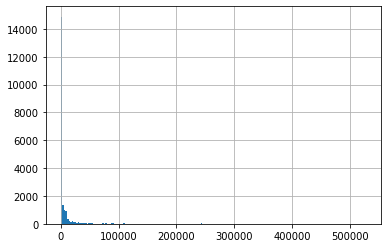

In [5]:
df.case_resolution_time__c.hist(bins=200)

## Inspection: cases with only one activity

In [6]:
sub = df.loc[df.task_count < 2]
sub.head()

Empty DataFrame
Columns: [case_id, case_type, task_id, task_tasksubtype, ressource, ressource_role, case_owner_role, case_topic, case_requires_rework__c, case_closure_code__c, case_milestonestatus, case_resolution_time__c, nps_createddate, nps_response_complete, nps_promoter, nps_detractor, nps_response_value, task_count, task_number, date_case_created, date_case_closed, date_task_created, year, month, day, weekday, hour]
Index: []

[0 rows x 27 columns]

# Get duration per task

In [7]:
cases = list(set(df.case_id.values))
print(len(cases))

7035


In [8]:
#placeholder for all rows
evlog = []

#go over all cases
for caseid in cases:
    
    #subset the case
    sub_case = df.loc[df.case_id == caseid]
    
    print(str(caseid),"len:",str(len(sub_case)))
    
    sub_case.index = list(range(0,len(sub_case)))
    
    #if more than one activity, calculate time between
    if len(sub_case) > 1:
        
        #go over each activity
        for t in sub_case.index:
            #print(t)
            activity_start = sub_case.loc[t].date_task_created
            
            #if next activity is not last activity, get next timestep
            if t+1 < len(sub_case):
                next_activity_start = sub_case.loc[t+1].date_task_created
                
            #if next activity is the last activity, use closed date
            else:
                next_activity_start = sub_case.loc[t].date_case_closed
            
            #calculate difference between events, and get duration:
            duration = next_activity_start - activity_start
            duration = duration.total_seconds()/60/60 #hours
            
            #if duration is invalid, dont include the activity
            if duration >= 0:

                #activity-timestep pair
                sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)

                #append results
                sub_case["activity_duration_hrs"] = duration
                evlog.append(sub_case)
    
    #if length is only one, use custom duration
    else:
        
        activity_start = sub_case.loc[0].date_task_created
        
        next_activity_start = sub_case.loc[0].date_case_closed
        
        #calculate difference between events, and get duration:
        duration = next_activity_start - activity_start

        if duration.days >= 0:
            #activity-timestep pair
            sub_case["activity_timestep"] = str(sub_case.loc[0].task_number) + "_" + str(sub_case.loc[0].task_tasksubtype)

            #append results
            sub_case["activity_duration_hrs"] = duration.total_seconds()/60/60
            evlog.append(sub_case)
        
evlog_df = pd.concat(evlog, ignore_index=True)
evlog_df

1966094 len: 4
2064399 len: 2
2031641 len: 2
1966106 len: 2
1736735 len: 3
1703972 len: 4
2097190 len: 3
1703989 len: 2
1703997 len: 4
1703998 len: 2
1704006 len: 2
2064455 len: 2
1704008 len: 3
2064456 len: 4
2064460 len: 3
2097234 len: 2
2097249 len: 3
1704034 len: 2
1966183 len: 3
1704041 len: 2
2097258 len: 2
1704048 len: 2
2097264 len: 2
1704052 len: 3
2064500 len: 6
1704067 len: 2
2064518 len: 7
1704098 len: 3
2064568 len: 2
1704121 len: 4
2064590 len: 2
1736913 len: 2
2031825 len: 2
2031828 len: 2
2064598 len: 3
1736924 len: 4
1933535 len: 3
2031845 len: 2
2097381 len: 2
1704176 len: 3
1933553 len: 3
1736947 len: 2
1704195 len: 2
2064645 len: 3
1933580 len: 4


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2031884 len: 2
1736978 len: 10
2064658 len: 2
2064660 len: 3
2097432 len: 2
1736991 len: 2
1933604 len: 2
2064677 len: 3
1704234 len: 4
2064684 len: 4
2097460 len: 3
2031929 len: 3
1638729 len: 4
1704284 len: 3
1900892 len: 3
1900904 len: 4
1737067 len: 5
1900909 len: 3
2031991 len: 3
1900920 len: 2
1737103 len: 4
2097552 len: 2
1900946 len: 2
1966484 len: 3
1900955 len: 2
1900958 len: 2
1737125 len: 2
1737130 len: 2
1900978 len: 2
2097593 len: 2
1737158 len: 2
2064850 len: 2
1999319 len: 3
2064860 len: 3
2097629 len: 2
2097635 len: 2
1737188 len: 4
2064881 len: 3
1737208 len: 2
1901063 len: 2
1901064 len: 2
1901065 len: 2
1802764 len: 10
2032142 len: 3
2097690 len: 3
1737244 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2064924 len: 7
1737245 len: 2
1901093 len: 3
2097723 len: 5
1901122 len: 3
1901129 len: 3
2097738 len: 2
2097737 len: 2
1901145 len: 2
1901152 len: 2
2097768 len: 3
1737324 len: 3
1737325 len: 3
1737327 len: 3
1737331 len: 2
1901176 len: 3
1966714 len: 2
2097786 len: 2
1901180 len: 3
2097791 len: 4
1901184 len: 6
2032260 len: 2
1737350 len: 3
2097806 len: 3
1737365 len: 2
2032278 len: 2
2097823 len: 2
1540770 len: 2
2032296 len: 3
1737387 len: 3
2097836 len: 3
2032308 len: 3
2065078 len: 2
1737403 len: 2
2065083 len: 2
2065085 len: 3
2097854 len: 2
1737410 len: 2
2097858 len: 4
2097861 len: 3
1737417 len: 3
1737418 len: 3
1737426 len: 2
1966808 len: 3
2032346 len: 3

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca


2097882 len: 3
1737441 len: 2
2032354 len: 3
2065129 len: 3
2032362 len: 2
2065138 len: 3
2097908 len: 2
2097911 len: 3
1737467 len: 2
1737474 len: 3
2032389 len: 2
2097928 len: 2
1737481 len: 7
2065165 len: 3
1704719 len: 2
2097944 len: 3
2097954 len: 4
1737521 len: 3
2065201 len: 2
1803059 len: 2
1737537 len: 2
1803073 len: 2
1803078 len: 2
1966919 len: 2
1803080 len: 3
2065227 len: 9
1704780 len: 5
1737562 len: 2
1737564 len: 2
1803100 len: 3
2098016 len: 7
1803105 len: 5
1966946 len: 2
2032483 len: 5
1540966 len: 5
1868646 len: 3
1737585 len: 11
2065266 len: 5
2098035 len: 4
2065277 len: 2
2065286 len: 3
2032535 len: 3
1803165 len: 2
2098078 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1704878 len: 2
1737647 len: 2
2065329 len: 2
2065338 len: 2
2065343 len: 2
1803203 len: 2
2032580 len: 2
1803213 len: 3
2065358 len: 3
1704911 len: 2
1704912 len: 2
1803216 len: 5
1967063 len: 2
1901528 len: 3
2032600 len: 3
2098139 len: 2
1541089 len: 2
2098145 len: 2
2065385 len: 2
1967087 len: 3
2065392 len: 3
2032623 len: 2
2065401 len: 2
1704968 len: 6
1704971 len: 4
1803275 len: 3
1803284 len: 3
1803285 len: 3
2032671 len: 4
2065442 len: 2
1803301 len: 3
2032691 len: 3
1803320 len: 6
2032705 len: 4
2065486 len: 3
1803351 len: 2
2065499 len: 4
1705080 len: 2
1803394 len: 3
1705113 len: 6
1803438 len: 2
2065584 len: 3
2032822 len: 3
2032826 len: 2
1705151 len: 2
1705154 len: 3
1705156 len: 4
1803471 len: 3
1705173 len: 2
1803480 len: 3
1803486 len: 2
2032864 len: 2
1705188 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2032870 len: 3
1639655 len: 2
1803498 len: 2
2065651 len: 2
2065652 len: 4
2065655 len: 2
1705215 len: 3
1705224 len: 3
2098443 len: 2
1705230 len: 4
2065683 len: 3
2032919 len: 2
2065687 len: 5
2098457 len: 2
2098458 len: 3
2098466 len: 2
1803555 len: 3
1967399 len: 3
2098473 len: 3
2000170 len: 2
2032938 len: 3
2098481 len: 2
2065715 len: 3
2065723 len: 3
2098493 len: 2
2098496 len: 2
1967430 len: 2
2065735 len: 2
2098503 len: 3
1967436 len: 2
1967466 len: 3
2098556 len: 3
2000256 len: 3
1803662 len: 3
1803663 len: 2
1705370 len: 5
2033058 len: 3
2065827 len: 2
2033064 len: 2
1803692 len: 3
2098610 len: 4
1803699 len: 2
1803707 len: 3
2033085 len: 4
1803711 len: 7
1902021 len: 2
1803726 len: 3
1934803 len: 3
1934808 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1803739 len: 3
2098653 len: 4
1934828 len: 3
2033142 len: 3
1934844 len: 2
1934871 len: 2
1902108 len: 5
1803808 len: 2
1803809 len: 2
2033185 len: 4
2098729 len: 3
1803826 len: 2
2033217 len: 3
1803844 len: 2
1803850 len: 6
2098762 len: 3
1902160 len: 3
2098768 len: 2
1705558 len: 2
2033238 len: 2
2033242 len: 2
1902178 len: 3
1934948 len: 2
1902182 len: 4
1934955 len: 2
1705583 len: 6
1934962 len: 2
2098815 len: 6
2066048 len: 2
1705608 len: 2
1902221 len: 3
2033308 len: 7
1902240 len: 2
1705640 len: 3
2098861 len: 2
2098880 len: 3
1705674 len: 6
2098905 len: 2
2098906 len: 3
1705704 len: 3
2098921 len: 2
2098942 len: 3
2098960 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1804057 len: 3
1902383 len: 2
2098998 len: 4
1705804 len: 2
1902417 len: 2
2099026 len: 4
1705820 len: 3
1804124 len: 3
2033505 len: 2
2099041 len: 2
2033511 len: 2
2033520 len: 2
1804146 len: 3
1804147 len: 2
1902454 len: 3
1902456 len: 2
1804154 len: 11
2033532 len: 4
2033534 len: 3
1902469 len: 3
1804166 len: 2
1902474 len: 2
2099082 len: 4
2099083 len: 4
1705872 len: 2
2000784 len: 2
2033553 len: 2
1804196 len: 4
2099134 len: 2
1804225 len: 3
1705924 len: 2
1902536 len: 2
2099147 len: 3
1705933 len: 3
1902542 len: 7
2066386 len: 3
1705940 len: 2
1804244 len: 4
2033627 len: 2
1705956 len: 4
1902564 len: 2
1705959 len: 6
1902568 len: 2
1902574 len: 4
1902576 len: 4
1902579 len: 3
2033671 len: 6


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1705992 len: 2
1705996 len: 3
1902608 len: 2
1902609 len: 2
2033681 len: 2
1706007 len: 3
1804317 len: 2
1902622 len: 2
2033702 len: 2
1902644 len: 2
1706046 len: 3
1706048 len: 3
1804361 len: 4
1640522 len: 4
1902673 len: 2
1706066 len: 5
1804370 len: 3
1804374 len: 3
1902680 len: 2
1706074 len: 2
1902682 len: 2
2033774 len: 2
1706095 len: 3
2099313 len: 3
1804410 len: 2
1935488 len: 5
2033796 len: 4
1902726 len: 2
1706131 len: 3
1804436 len: 4
1804435 len: 2
2001043 len: 6
1706143 len: 2
1804451 len: 2
2099367 len: 3
1804457 len: 3
2033836 len: 2
1902768 len: 3
2066610 len: 4
1804481 len: 2
1804482 len: 6
2099395 len: 3
2033869 len: 3
1804495 len: 3
1706192 len: 2
2099408 len: 3
2033882 len: 4


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1902812 len: 2
2001118 len: 4
2066659 len: 3
2066662 len: 2
1902824 len: 2
1706220 len: 3
2099436 len: 2
2099439 len: 2
1935616 len: 4
2066689 len: 2
1902850 len: 3
1935618 len: 3
2099461 len: 2
1706252 len: 2
2066703 len: 4
2066704 len: 5
1902866 len: 2
2033940 len: 3
1804573 len: 4
2099492 len: 3
2099501 len: 3
2099504 len: 3
1902906 len: 15
2033979 len: 2
2099520 len: 2
2066758 len: 3
1804616 len: 3
2034002 len: 2
1902933 len: 2
2066778 len: 3
1706333 len: 2
1902941 len: 3
2066790 len: 3
2099561 len: 3
1902954 len: 2
2099567 len: 2
1902960 len: 7
1902963 len: 2
1706356 len: 2
2066805 len: 3
1804663 len: 4
2034048 len: 3
2034050 len: 3
1902983 len: 3
1902984 len: 4
2066823 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1902992 len: 3
1706387 len: 4
2034075 len: 2
2099619 len: 5
1903015 len: 2
2066856 len: 3
2066857 len: 3
1903022 len: 3
2034095 len: 3
2099635 len: 4
1706420 len: 2
1706430 len: 3
1903043 len: 2
2066886 len: 5
1903050 len: 2
2066894 len: 2
2066898 len: 2
1706451 len: 3
1706453 len: 3
2066905 len: 4
1804763 len: 4
2066910 len: 2
1804779 len: 2
2034166 len: 3
2066934 len: 2
1739277 len: 3
2066965 len: 2
1706520 len: 2
1739291 len: 4
2066976 len: 2
1542693 len: 4
2034215 len: 2
2034226 len: 3
1804864 len: 6
2034242 len: 2
2067011 len: 2
2099788 len: 4
1804878 len: 3
1542739 len: 3
2099823 len: 2
2034288 len: 3
1804916 len: 3
2067062 len: 3
2001530 len: 2
2067066 len: 2
1739390 len: 3
2001557 len: 3
1903255 len: 4
2067097 len: 2
2067098 len: 2
1968818 len: 2
2067138 len: 2
2067139 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2099910 len: 2
1542862 len: 2
2067155 len: 2
1542873 len: 2
1936092 len: 2
2067164 len: 3
2001631 len: 2
2034410 len: 2
1936130 len: 2
2001671 len: 2
1739532 len: 2
1903379 len: 3
2001689 len: 2
1903390 len: 2
1903396 len: 3
1936165 len: 5
2034474 len: 2
1542955 len: 2
2034478 len: 2
1739568 len: 3
1805105 len: 3
2067250 len: 3
1739571 len: 3
1739572 len: 2
1903412 len: 5
1542966 len: 2
1805110 len: 3
2001720 len: 2
1542963 len: 2
2067262 len: 4
2034499 len: 2
2001732 len: 4
2067270 len: 3
1936200 len: 5
2001741 len: 3
2067280 len: 2
1903444 len: 2
2100053 len: 2
2100054 len: 2
2100069 len: 3
1903462 len: 4
1903476 len: 2
2100090 len: 3
1706878 len: 2
1706879 len: 4
1936255 len: 2
1903490 len: 2
2034567 len: 3
2100114 len: 3
1739668 len: 3
2034580 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1903510 len: 2
1903514 len: 2
1805212 len: 2
1936284 len: 3
1739677 len: 4
2100127 len: 2
1706913 len: 2
1903522 len: 2
1739689 len: 4
1543090 len: 2
1706931 len: 2
1739704 len: 6
1739708 len: 2
1936317 len: 2
1969085 len: 2
2067391 len: 2
1543107 len: 3
1903559 len: 3
2034631 len: 3
2067399 len: 2
2034639 len: 2
1805264 len: 3
1969104 len: 2
2100180 len: 5
1706972 len: 2
1805277 len: 3
2100192 len: 3
1936353 len: 3
2100207 len: 2
1739760 len: 3
1706993 len: 2
1805297 len: 3
1903614 len: 3
2100222 len: 3
1936389 len: 2
2067462 len: 2
1903624 len: 3
2067464 len: 3
1707017 len: 2
1969164 len: 3
1969165 len: 2
1805327 len: 2
1805331 len: 2
2100247 len: 5
2100252 len: 2
1707038 len: 3
1969183 len: 2
2034721 len: 5
1805346 len: 4
1969188 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1969191 len: 3
2100263 len: 4
2100265 len: 2
2001962 len: 2
1739822 len: 12
1936431 len: 4
2034737 len: 2
1805367 len: 3
1805382 len: 3
1969227 len: 2
2034769 len: 2
1805404 len: 2
2034780 len: 3
1805408 len: 2
1936484 len: 2
1707113 len: 2
1805425 len: 2
2067577 len: 3
1936506 len: 2
2067582 len: 2
2034817 len: 4
1543301 len: 2
1707147 len: 2
2067596 len: 2
1707159 len: 2
1805466 len: 2
2067614 len: 2
1805473 len: 4
2002081 len: 3
1707172 len: 3
1805478 len: 2
1805485 len: 4
1936558 len: 3
2067632 len: 3
1707186 len: 3
1936564 len: 2
2034870 len: 3
1707209 len: 2
1936596 len: 2
1969364 len: 4
1805553 len: 2
1805556 len: 2
2067704 len: 2
1936637 len: 4
1936642 len: 7
1969414 len: 2
1805583 len: 2
1936666 len: 6
1707299 len: 4


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1969447 len: 2
1740074 len: 3
1936682 len: 2
1707312 len: 3
1740087 len: 3
2067771 len: 2
2035004 len: 2
2067780 len: 3
2067781 len: 2
1936711 len: 2
1707344 len: 2
1707345 len: 2
1707352 len: 17
2067804 len: 3
1936744 len: 3
2002285 len: 2
1969518 len: 2
1936751 len: 2
2035056 len: 3
1740148 len: 5
2067835 len: 3
2035070 len: 2
2067840 len: 6
1805697 len: 4
1969537 len: 2
1969540 len: 4
2002312 len: 2
1969559 len: 6
2002336 len: 3
2100653 len: 3
1740206 len: 2
2067888 len: 3
1740214 len: 2
1707447 len: 11
2067915 len: 5
1707473 len: 2
2067922 len: 2
1740241 len: 2
2035157 len: 3
2035159 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1936868 len: 3
1969640 len: 2
2035177 len: 3
1904110 len: 2
1969651 len: 3
1969652 len: 3
1969653 len: 2
1936893 len: 5
2067968 len: 3
1740290 len: 2
1740291 len: 4
1904134 len: 4
1936908 len: 2
1740301 len: 3
1740302 len: 3
1904144 len: 2
1969681 len: 5
1740307 len: 3
1969687 len: 3
1740313 len: 3
2067996 len: 2
2067997 len: 2
1904167 len: 5
1969706 len: 2
2068010 len: 4
1740335 len: 2
1805878 len: 2
2068022 len: 2
1740343 len: 5
1936954 len: 6
1805884 len: 2
1936969 len: 3
1936971 len: 6
1969739 len: 2
1969742 len: 2
1740393 len: 3
1740397 len: 4
2100848 len: 4
1707635 len: 2
1904254 len: 3
1937027 len: 2
1904261 len: 2
1707657 len: 3
1805967 len: 4
1904275 len: 4


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1937044 len: 3
1805988 len: 3
2100902 len: 2
1937068 len: 2
1937069 len: 3
2035378 len: 2
1904325 len: 3
2100943 len: 4
1806033 len: 3
2100956 len: 4
2100959 len: 4
1707749 len: 3
2035448 len: 2
1740546 len: 3
1904386 len: 2
1740549 len: 2
2100998 len: 2
1740553 len: 3
2101010 len: 2
1707795 len: 2
1806103 len: 3
1806107 len: 2
1740572 len: 9
1904412 len: 2
2101021 len: 3
2101026 len: 3
1904423 len: 3
2101032 len: 3
2035500 len: 5
1806144 len: 6
1904448 len: 3
1707847 len: 2
2101064 len: 2
1806159 len: 2
1740626 len: 4
1937234 len: 2
2101076 len: 3
2035546 len: 4
2101087 len: 4
1904483 len: 2
2101097 len: 2
1806187 len: 2
2035564 len: 3
1806189 len: 2
2101102 len: 2
1904499 len: 2
1740660 len: 2
1904501 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1740668 len: 5
1740670 len: 2
1937278 len: 3
1806207 len: 2
1904514 len: 3
1937282 len: 3
1740675 len: 3
1740677 len: 5
1937299 len: 2
2101140 len: 3
1740694 len: 2
2101155 len: 3
1740715 len: 4
2101166 len: 2
1806271 len: 2
1904578 len: 2
1707972 len: 3
1937350 len: 3
1740754 len: 2
1937364 len: 2
1806294 len: 3
2035672 len: 4
2035674 len: 2
2035678 len: 2
2101218 len: 3
1806307 len: 2
2035686 len: 2
1708008 len: 2
2035689 len: 5
1740783 len: 3
2101232 len: 4
1904627 len: 3
1904637 len: 3
2101245 len: 3
1904648 len: 2
1740813 len: 3
1806356 len: 10
1904670 len: 3
1740834 len: 3
1740836 len: 2
1740838 len: 2
1806374 len: 2
1544240 len: 2
1904688 len: 2
1740850 len: 2
1937462 len: 7
1904702 len: 6


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1740865 len: 3
1544269 len: 2
1740878 len: 2
1806413 len: 2
1937491 len: 3
1544279 len: 2
1740891 len: 3
1806427 len: 2
1740895 len: 3
1937503 len: 3
1740900 len: 2
1708134 len: 2
1937513 len: 2
1806445 len: 2
1937520 len: 2
1937526 len: 2
1806456 len: 2
1806458 len: 3
1544317 len: 2
1904766 len: 4
1708162 len: 2
1544323 len: 2
1806483 len: 3
2003094 len: 3
1544353 len: 2
1708199 len: 2
1544367 len: 3
1708208 len: 4
1708207 len: 2
2003122 len: 3
1740977 len: 3
1740992 len: 3
1544385 len: 2
1544394 len: 3
1544397 len: 3
1741019 len: 5
1741028 len: 4
2035958 len: 2
1544441 len: 3
1806589 len: 2
1806590 len: 2
1741055 len: 2
1544463 len: 3
1741073 len: 3
1806621 len: 5
2036027 len: 2
2003262 len: 2
1937732 len: 4
1544518 len: 2
1904978 len: 4
1937750 len: 2
1544536 len: 4
1937758 len: 5
1708389 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1544550 len: 5
1708396 len: 2
1708399 len: 2
1937775 len: 2
1741180 len: 2
1708413 len: 2
2068867 len: 3
1708420 len: 2
1741188 len: 2
1741196 len: 3
2036109 len: 2
2068878 len: 2
1708432 len: 2
1708438 len: 5
1741207 len: 2
1708443 len: 4
2068891 len: 3
1741215 len: 2
2068900 len: 2
1937834 len: 4
1741232 len: 2
1806775 len: 2
1544634 len: 2
2068923 len: 2
1937856 len: 3
1708483 len: 3
2068933 len: 3
1905099 len: 2
2068942 len: 2
1708508 len: 4
2068962 len: 2
1544676 len: 3
1708518 len: 3
2068969 len: 3
1708531 len: 4
2068979 len: 3
1806845 len: 2
1806848 len: 3
2069004 len: 2
2069016 len: 2
1806878 len: 3
2069022 len: 3
1937952 len: 6
1806883 len: 3
2003491 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2036267 len: 2
2069047 len: 3
1741370 len: 5
1937980 len: 4
1741380 len: 2
2069061 len: 3
1937992 len: 2
1544777 len: 2
1741385 len: 2
1741392 len: 4
1544799 len: 2
1938016 len: 3
1544805 len: 2
1806949 len: 3
1708652 len: 2
2036332 len: 2
1544818 len: 2
1544826 len: 9
1938067 len: 3
1544853 len: 3
1938084 len: 2
1741479 len: 3
1708714 len: 4
1708717 len: 2
2036397 len: 3
1938099 len: 2
1708725 len: 2
1741495 len: 2
1807036 len: 2
1741504 len: 3
1807048 len: 4
1741513 len: 3
2003660 len: 6
1938125 len: 3
1708755 len: 3
1807060 len: 2
1741533 len: 2
1807079 len: 2
1708786 len: 3
1741558 len: 2
1807100 len: 3
1708803 len: 2
1708806 len: 2
1544975 len: 3
1938194 len: 2
1938201 len: 2
1544991 len: 3
1938212 len: 4
1708841 len: 2
1741614 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1545008 len: 3
1741617 len: 2
2036545 len: 2
1708867 len: 2
1807173 len: 6
1708870 len: 3
2036549 len: 2
1741641 len: 2
2036553 len: 3
1807179 len: 4
1741660 len: 5
1938270 len: 3
1807199 len: 2
2036577 len: 3
1643362 len: 4
1807202 len: 2
1741671 len: 2
1741681 len: 3
1938290 len: 2
1708915 len: 3
1708925 len: 3
2036607 len: 4
1741699 len: 3
1708937 len: 5
1807258 len: 4
1741729 len: 3
1741730 len: 3
1708965 len: 2
2036646 len: 3
1807271 len: 3
1741736 len: 3
1938343 len: 3
1938345 len: 2
2003885 len: 2
1545135 len: 3
1905593 len: 3
1938381 len: 4
1840084 len: 2
1905621 len: 2
1741785 len: 2
1807324 len: 2
1807333 len: 2
2003943 len: 2
2036719 len: 2
1741818 len: 3
1905663 len: 3
1807361 len: 3
1905669 len: 3
2036742 len: 2
1840139 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1545242 len: 2
2036769 len: 2
1807395 len: 3
1840166 len: 2
2004008 len: 3
1807401 len: 2
1545260 len: 2
1709101 len: 3
1807407 len: 2
1905711 len: 2
2036791 len: 3
1545305 len: 2
1741914 len: 3
1807456 len: 2
1545314 len: 2
1807458 len: 3
2069604 len: 3
1741926 len: 4
1709184 len: 2
1905792 len: 4
1741961 len: 4
1905801 len: 7
2036877 len: 4
2004113 len: 2
1807511 len: 3
2036889 len: 2
1774751 len: 3
1545376 len: 2
2036902 len: 2
2069670 len: 3
1807532 len: 3
1774778 len: 2
1545408 len: 2
1807554 len: 3
1807556 len: 3
2036936 len: 3
1545423 len: 2
2069719 len: 2
1709273 len: 3
1709276 len: 2
2069726 len: 3
2036969 len: 3
1545459 len: 3
2004212 len: 4
2036979 len: 3
2036988 len: 3
1545471 len: 5


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2069760 len: 4
1774852 len: 3
2037013 len: 2
1774874 len: 2
1545502 len: 3
2069791 len: 2
1545504 len: 4
1709354 len: 3
1774891 len: 2
1709357 len: 3
2037041 len: 3
1709378 len: 2
2069827 len: 4
2037062 len: 3
2069830 len: 4
1545543 len: 3
1545548 len: 6
1774929 len: 3
1840470 len: 2
1545565 len: 3
1545566 len: 2
1545631 len: 3
1643949 len: 2
1545665 len: 3
1742273 len: 2
1775046 len: 2
1775051 len: 2
1545677 len: 3
1742285 len: 3
1742288 len: 2
1742289 len: 3
2037204 len: 2
1709533 len: 3
1742306 len: 3
1545702 len: 2
1545713 len: 3
2037233 len: 2
1545716 len: 3
2037243 len: 5
1709565 len: 3
2037254 len: 3
1545739 len: 2
1775120 len: 2
1545745 len: 3
1545757 len: 2
1742368 len: 3
2037280 len: 3
1775139 len: 2
1709610 len: 2
1742389 len: 2
2037304 len: 4


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1742395 len: 2
1742400 len: 3
2037321 len: 3
1742411 len: 2
1709644 len: 2
2037329 len: 7
1545814 len: 2
1742432 len: 2
1709666 len: 3
1545832 len: 3
1742446 len: 3
2037393 len: 3
1742487 len: 17
1775256 len: 3
1742489 len: 2
2070170 len: 2
1709725 len: 2
1545887 len: 2
1709727 len: 3
1742495 len: 5
1775267 len: 2
2037413 len: 7
2070181 len: 3
1742505 len: 2
1545898 len: 3
1545901 len: 2
1742515 len: 2
2037430 len: 3
2037434 len: 2
2037447 len: 3
2037458 len: 5
1545939 len: 2
1545941 len: 5
2102998 len: 2
1545945 len: 2
1742553 len: 3
2037472 len: 3
2037475 len: 2
2103017 len: 3
1742575 len: 2
1775345 len: 4
1545979 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1742592 len: 2
1775361 len: 3
1742598 len: 3
1742599 len: 3
1545995 len: 3
1742603 len: 2
2037515 len: 2
1546008 len: 2
1742618 len: 3
2037531 len: 2
2103071 len: 2
1742626 len: 2
1546019 len: 2
1742652 len: 4
2103100 len: 2
1742653 len: 2
1742656 len: 2
1742657 len: 4
2037577 len: 3
1775434 len: 7
1742675 len: 2
1742676 len: 3
1742677 len: 5
2103133 len: 2
1775457 len: 2
2103148 len: 2
2004854 len: 5
1742712 len: 3
1939321 len: 3
1546131 len: 2
2037654 len: 3
2103191 len: 2
1546138 len: 2
1742753 len: 2
1906594 len: 3
2004898 len: 3
1546150 len: 5
1742759 len: 2
1939366 len: 2
2103206 len: 3
2103210 len: 4
2037680 len: 2
2103216 len: 2
1546163 len: 5
1775546 len: 2
1775549 len: 2
1939396 len: 8


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1546189 len: 4
2103247 len: 4
1775568 len: 2
2103248 len: 4
1710034 len: 2
1808337 len: 2
2070484 len: 2
1775588 len: 3
2070501 len: 3
2103271 len: 5
1775595 len: 3
2004971 len: 2
1742830 len: 2
1808380 len: 3
1808383 len: 2
2070528 len: 2
1546241 len: 3
2037759 len: 3
1710085 len: 3
1546247 len: 4
1939468 len: 2
2103310 len: 2
2070546 len: 2
2103315 len: 3
2037782 len: 2
1546271 len: 3
1546272 len: 2
1939495 len: 7
1480744 len: 2
2103338 len: 2
1546290 len: 3
1710132 len: 2
1742904 len: 4
1546313 len: 4
1546315 len: 2
1939547 len: 1
1546340 len: 4
1710181 len: 2
1546345 len: 2
2005100 len: 14
1546351 len: 4
2103424 len: 3
1546370 len: 3
1546371 len: 3
1939588 len: 3
1742988 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2037906 len: 2
1939605 len: 3
2005142 len: 2
1939607 len: 3
2103449 len: 3
1906842 len: 4
1906851 len: 3
1546406 len: 3
1546407 len: 2
1906860 len: 2
1906876 len: 3
1546429 len: 5
2103498 len: 3
1939659 len: 3
2037969 len: 3
1546465 len: 2
1939690 len: 3
2103537 len: 3
2070773 len: 2
2038006 len: 3
2038009 len: 3
2103545 len: 2
2103557 len: 4
2103561 len: 2
1906959 len: 2
1546531 len: 4
1743145 len: 2
1906992 len: 3
1546554 len: 2
1907003 len: 2
2103612 len: 3
1907006 len: 2
1743170 len: 2
2103625 len: 4
1743181 len: 2
1907022 len: 3
1907033 len: 3
2103648 len: 4
1907048 len: 3
1546603 len: 5
1907051 len: 2
1743219 len: 3
1546615 len: 3
1546625 len: 2
1546626 len: 2
1546630 len: 2
1907088 len: 2
1907095 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1710489 len: 3
1743261 len: 2
1546656 len: 4
1546663 len: 3
2103730 len: 2
1907129 len: 2
2103737 len: 2
2005437 len: 4
1907142 len: 3
1743307 len: 2
1710548 len: 2
1907163 len: 3
1546722 len: 2
1743330 len: 3
2103781 len: 2
1546727 len: 2
1546729 len: 3
2103787 len: 4
2005487 len: 10
1710576 len: 2
1743344 len: 4
1776125 len: 3
1743358 len: 3
2103822 len: 3
2103826 len: 2
2103831 len: 2
1743384 len: 2
1546790 len: 5
1546797 len: 2
1743406 len: 8
1710652 len: 2
1776191 len: 2
1710659 len: 4
1776195 len: 2
2038346 len: 2
2103885 len: 4
1743438 len: 2
1743446 len: 4
2005592 len: 4
1907289 len: 6
1776221 len: 3
2103905 len: 3
1907300 len: 2
2103912 len: 3
1776233 len: 2
1907307 len: 3
1743468 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1743469 len: 3
1546862 len: 7
2103915 len: 3
2038385 len: 3
2071157 len: 2
1546873 len: 2
1743485 len: 2
1776260 len: 2
2005638 len: 3
1907337 len: 2
2038411 len: 2
1743500 len: 3
2005644 len: 2
1743503 len: 3
1907344 len: 2
1743507 len: 3
1546900 len: 5
1743508 len: 3
1776279 len: 3
1743513 len: 2
2005657 len: 4
2038433 len: 2
2103982 len: 3
2103983 len: 3
1907382 len: 3
2071224 len: 2
1743554 len: 6
1907399 len: 2
1743560 len: 2
1907405 len: 2
2038477 len: 3
2104020 len: 3
2104027 len: 2
2005728 len: 2
2038505 len: 2
1776363 len: 2
2038508 len: 2
1776365 len: 2
1743598 len: 2
2104046 len: 3
1907437 len: 3
2038507 len: 3
1907445 len: 3
1907446 len: 3
1907462 len: 2
1743626 len: 5
2005773 len: 5
1841934 len: 4
1547027 len: 3
1743641 len: 3
2005789

<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

 len: 2
2005799 len: 4
2005801 len: 2
2038575 len: 2
1743665 len: 5
2104115 len: 2
2104116 len: 2
1776442 len: 2
1547070 len: 3
1907518 len: 2
1809220 len: 2
1907525 len: 3
1809230 len: 3
2071377 len: 2
1547100 len: 2
2071388 len: 2
2071396 len: 2
1809253 len: 2
2038634 len: 2
2071404 len: 2
2005869 len: 3
2038638 len: 3
1547119 len: 3
1547120 len: 2
2071407 len: 3
2104181 len: 2
1547145 len: 3
1907594 len: 4
1973133 len: 3
1907600 len: 2
1907603 len: 4
1907604 len: 4
1973139 len: 3
1907611 len: 4
1776540 len: 3
2005917 len: 2
1776549 len: 7
1547174 len: 4
2104231 len: 3
1547182 len: 4
1973168 len: 4
1743793 len: 3
1547192 len: 2
1547199 len: 2
1743808 len: 2
1776581 len: 6
2038726 len: 3
1776587 len: 4
1776606 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2071524 len: 2
2071529 len: 2
1743852 len: 3
2104303 len: 2
2071537 len: 3
1743863 len: 4
1547259 len: 5
1547265 len: 3
2038785 len: 4
2071556 len: 2
1743877 len: 2
1547270 len: 2
2038793 len: 2
1547276 len: 2
2104332 len: 3
1907726 len: 3
1907729 len: 3
1776658 len: 2
1743900 len: 3
2038819 len: 4
1711144 len: 4
2104365 len: 3
1547312 len: 2
2104370 len: 3
2038836 len: 3
1907766 len: 2
2104374 len: 4
1547328 len: 3
2038863 len: 9
1711187 len: 3
2038872 len: 2
1907809 len: 3
2071649 len: 5
1547365 len: 3
1711205 len: 2
1711207 len: 2
1907816 len: 3
1940584 len: 2
2006131 len: 2
1907829 len: 5
1711224 len: 3
1907844 len: 3
2071692 len: 3
1907856 len: 3
2104465 len: 2
2038932 len: 3
2038937 len: 2
1547418 len: 3
1744037 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1547434 len: 3
2071725 len: 2
2104493 len: 2
1547441 len: 2
2071730 len: 2
2104499 len: 2
2104502 len: 3
2038969 len: 3
1547455 len: 2
1744077 len: 3
2071766 len: 2
1744090 len: 2
2071773 len: 3
1776864 len: 4
1907936 len: 2
1776869 len: 3
1907947 len: 3
2071789 len: 3
2071794 len: 2
1547509 len: 2
1907958 len: 2
1776890 len: 2
2071802 len: 3
2039037 len: 2
1744126 len: 2
1907967 len: 2
2039039 len: 2
1744129 len: 3
2071807 len: 3
1940741 len: 2
2071813 len: 2
1547528 len: 2
1940745 len: 2
2039051 len: 7
1547533 len: 4
1907983 len: 2
1744146 len: 2
1744151 len: 3
1940759 len: 3
1744159 len: 2
2071841 len: 2
1547555 len: 3
1744164 len: 2
1908007 len: 3
2039085 len: 3
1744179 len: 3
1744185 len: 2
1908030 len: 3
1547585 len: 3
1744200 len: 3
1744202 len: 2
1908042 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1908043 len: 2
2039122 len: 2
1547616 len: 3
1547618 len: 2
2071909 len: 2
1547622 len: 2
1547623 len: 4
1744240 len: 3
1777010 len: 2
1777027 len: 2
1547658 len: 3
1547662 len: 3
1547668 len: 3
2104724 len: 2
2104751 len: 2
2104752 len: 2
1744305 len: 4
1711540 len: 2
1547715 len: 3
1777099 len: 8
1744332 len: 5
2039250 len: 3
1547733 len: 2
1547735 len: 5
1744346 len: 2
2072029 len: 3
1744350 len: 4
2039265 len: 2
1744358 len: 2
2104807 len: 3
1777128 len: 4
2104812 len: 2
2072051 len: 2
2072052 len: 3
2039287 len: 3
1777153 len: 2
2039301 len: 4
2104837 len: 2
1973768 len: 2
1744394 len: 2
2039306 len: 2
2104850 len: 2
1744403 len: 2
2104856 len: 2
1744422 len: 6
1973802 len: 3
1744427 len: 4
2104877 len: 5
1547824 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1777200 len: 2
1547826 len: 7
1744433 len: 2
1973813 len: 2
2039351 len: 2
2072119 len: 3
2104891 len: 2
1777214 len: 2
2006591 len: 2
1744458 len: 3
2006611 len: 3
1973845 len: 2
1547865 len: 5
2104924 len: 2
1973862 len: 2
1547887 len: 2
1547888 len: 2
1973890 len: 2
2104962 len: 6
2104968 len: 2
1744522 len: 3
1547920 len: 2
1973909 len: 2
1973910 len: 3
2104983 len: 2
1547929 len: 2
1744537 len: 3
2104994 len: 9
1744548 len: 3
1777317 len: 2
1547956 len: 4
1744565 len: 5
1744567 len: 2
2105018 len: 4
1973948 len: 4
1973950 len: 4
1973962 len: 2
2006731 len: 3
1744594 len: 4
1547988 len: 3
2006744 len: 4
2105051 len: 2
1842909 len: 3
2105055 len: 4
2006754 len: 2
1744612 len: 3
1548009 len: 2
2006761 len: 2
1744620 len: 3
2039533 len: 2
1974002 len: 3
2105077 len: 2
2006786 len: 2
2039556 len: 2
2006791 len: 3
1974046 len: 2
1548069 len: 2
2039590 len: 4
1548076 len: 2
1974066 len: 8
1548093 len: 3
2105150 len: 3
2105155 len: 2
1548103 len: 4
1974088 len: 4
2006858 len: 14
1810252 l

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2105305 len: 2
1712092 len: 4
1548253 len: 3
1548255 len: 2
2039777 len: 2
2105318 len: 2
2039796 len: 2
1712117 len: 2
2039811 len: 2
1548299 len: 2
1810443 len: 3
1974286 len: 2
1810449 len: 2
2039826 len: 2
2105365 len: 4
1548310 len: 3
1810458 len: 3
1810465 len: 3
1941540 len: 2
2039848 len: 2
1548338 len: 3
1548340 len: 3
1810486 len: 2
2039868 len: 3
1712193 len: 2
2039873 len: 2
2072646 len: 2
1941588 len: 3
1712214 len: 2
2105433 len: 2
2039901 len: 3
1548383 len: 3
2105441 len: 2
1908834 len: 2
2105447 len: 5
1548397 len: 8
2105459 len: 2
2105460 len: 7
2105467 len: 2
1548416 len: 2
1548454 len: 2
1548458 len: 2
1548466 len: 2
2040000 len: 2
2040019 len: 2
1548500 len: 2
2040024 len: 5
1974503 len: 4
2072814 len: 3
1548528 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1974515 len: 2
2105587 len: 2
1974519 len: 2
1548536 len: 3
1548538 len: 2
1974522 len: 4
2040060 len: 3
1974527 len: 5
2072850 len: 2
2105620 len: 3
2072855 len: 3
2040095 len: 3
1941805 len: 3
1974580 len: 2
1712449 len: 3
1712454 len: 2
1941833 len: 3
2072910 len: 3
1974607 len: 2
2105682 len: 3
1941859 len: 2
1941873 len: 2
2040178 len: 2
2105728 len: 3
2040203 len: 3
2105741 len: 5
1548688 len: 5
1941905 len: 3
2040213 len: 3
2072990 len: 3
2072994 len: 2
2073007 len: 5
1974714 len: 7
2073018 len: 2
1941952 len: 3
1974729 len: 10
2040268 len: 2
2040282 len: 6
2040284 len: 2
1941984 len: 3
1483233 len: 2
1483234 len: 2
1974757 len: 3
1941991 len: 2
2073073 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1974777 len: 3
1942017 len: 2
1942028 len: 2
1974796 len: 2
2105873 len: 3
1974806 len: 4
2073113 len: 2
1942042 len: 3
2105883 len: 3
2073126 len: 2
2105895 len: 2
1942058 len: 5
2073139 len: 3
1745467 len: 3
1548861 len: 2
2073158 len: 6
2073165 len: 2
2105966 len: 2
2073204 len: 4
1942134 len: 3
2105975 len: 3
2105979 len: 3
2073213 len: 3
1942143 len: 2
2105989 len: 3
2105993 len: 2
1942154 len: 2
2106002 len: 2
1974934 len: 3
1548956 len: 6
2106016 len: 2
2106019 len: 2
1942187 len: 3
1548972 len: 2
2106036 len: 3
2007734 len: 2
1548988 len: 5
1548989 len: 2
2040515 len: 3
2040520 len: 2
1549002 len: 2
2040522 len: 2
2106058 len: 2
1549005 len: 5
2040523 len: 2
2007763 len: 7
1549013 len: 3
1647317 len: 5
1712868

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

 len: 4
2073321 len: 3
2007799 len: 3
2106103 len: 3
2007801 len: 3
2040578 len: 2
2073349 len: 3
1647369 len: 2
2073358 len: 3
1647377 len: 2
2073378 len: 2
1942307 len: 7
1549092 len: 3
1647397 len: 3
2007846 len: 2
2040622 len: 3
2073391 len: 2
1712947 len: 3
1647416 len: 2
2040638 len: 3
1712959 len: 3
1712963 len: 3
2007877 len: 2
1942346 len: 2
1942354 len: 3
1942355 len: 6
1549140 len: 2
2073428 len: 3
1712982 len: 8
2073433 len: 4
1712989 len: 3
2007903 len: 2
1975138 len: 3
2073446 len: 3
1549168 len: 4
1975159 len: 2
1647492 len: 5
1549191 len: 5
1647499 len: 3
2073483 len: 3
1713037 len: 2
2007951 len: 4
1713041 len: 2
2106258 len: 2
1647511 len: 4
2040731 len: 2
1549222

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

 len: 3
1647534 len: 2
2040753 len: 5
2106290 len: 2
1549255 len: 3
2106314 len: 3
2040784 len: 5
1647578 len: 2
2106330 len: 3
1647581 len: 2
2040799 len: 2
1909730 len: 2
1549283 len: 3
1647590 len: 2
1713129 len: 2
1713133 len: 4
1647601 len: 3
2008051 len: 2
1647610 len: 4
2008058 len: 2
2073612 len: 5
1713167 len: 3
1549328 len: 2
2040849 len: 4
2073619 len: 2
1549335 len: 2
1713180 len: 4
2073630 len: 2
1713189 len: 3
2040871 len: 2
2073639 len: 3
1647660 len: 2
1549362 len: 4
2073650 len: 2
1713209 len: 2
2073659 len: 3
2040895 len: 3
2040903 len: 3
1549384 len: 2
1647688 len: 3
1713229 len: 2
1713232 len: 2
1909840 len: 7
1909843 len: 3
1549398 len: 2
2073690 len: 2
2073695 len: 5
1713260 len: 3
2040943 len: 3
1909874 len: 2

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca


2008178 len: 2
2106483 len: 2
2073718 len: 3
1713273 len: 2
1549434 len: 2
2106494 len: 2
1713284 len: 3
2106500 len: 3
1647750 len: 5
1549445 len: 3
2106505 len: 3
2073739 len: 4
1549452 len: 3
2106510 len: 2
2073748 len: 2
2106520 len: 2
1549467 len: 3
2073758 len: 3
1713314 len: 5
1942692 len: 2
2008235 len: 2
2106544 len: 2
1942705 len: 3
1713331 len: 3
1549496 len: 2
1811644 len: 4
1647811 len: 2
2073799 len: 16
1713353 len: 3
2008266 len: 3
2073805 len: 2
2106576 len: 3
2008275 len: 4
2106587 len: 2
1549532 len: 2
2008291 len: 2
1942760 len: 2
2008300 len: 3
1942781 len: 3
2073855 len: 5
2106633 len: 3
2008330 len: 2
1647886 len: 3
2073884 len: 6
2008350 len: 3
2106655 len: 3
1942818 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2106658 len: 2
1942836 len: 3
2041151 len: 2
2073923 len: 3
1942853 len: 2
1647946 len: 2
2008395 len: 2
1910094 len: 2
2073940 len: 3
2073944 len: 2
1942873 len: 4
1942878 len: 3
1910116 len: 2
1942892 len: 3
2073965 len: 2
2041204 len: 2
1942911 len: 3
2073986 len: 4
1910164 len: 2
2008470 len: 2
2074011 len: 6
1713564 len: 3
1648029 len: 3
1942945 len: 5
2041250 len: 4
1910180 len: 6
1549735 len: 2
2041260 len: 2
2074031 len: 3
1942960 len: 2
2041264 len: 3
1713590 len: 2
1910207 len: 2
1648066 len: 2
2008519 len: 2
2074064 len: 2
2008529 len: 3
1549790 len: 3
2041314 len: 3
2074089 len: 3
1779179 len: 2
2041334 len: 3
1910264 len: 3
1943032 len: 3
1811961 len: 3
1549835 len: 3
2074127 len: 3
1910298 len: 7
2074138 len: 2
2074150 len: 2
1943089 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1943094 len: 3
2008639 len: 2
2041413 len: 3
1549898 len: 3
2008650 len: 2
1910351 len: 2
2008658 len: 3
2074198 len: 2
1549919 len: 2
1910367 len: 3
1779297 len: 4
1910373 len: 2
1549932 len: 2
1648236 len: 3
1779309 len: 2
1910387 len: 2
1943160 len: 3
1549947 len: 2
1943165 len: 2
1910400 len: 2
2008709 len: 4
1549963 len: 2
1549965 len: 3
1943186 len: 2
1779348 len: 2
1910425 len: 2
1943197 len: 3
1648292 len: 2
1910439 len: 3
1910440 len: 2
1943219 len: 2
2074291 len: 3
1943228 len: 2
1648322 len: 2
1943236 len: 3
1615563 len: 2
1779403 len: 3
1943243 len: 2
1943245 len: 3
1812180 len: 2
1550040 len: 2
1550051 len: 2
2008803 len: 2
2074341 len: 3
1550060 len: 3
1648365 len: 2
1550062 len: 2
1976059 len: 2
2107132 len: 4
1910528 len: 5
1550081 len: 2
1943297 len: 2
1550083 len: 2
2041610 len: 4


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1550099 len: 3
1550108 len: 5
1550109 len: 2
1976099 len: 5
1550120 len: 3
1648425 len: 3
1812266 len: 4
1910578 len: 3
1550134 len: 2
1910583 len: 2
2008889 len: 6
1976125 len: 3
2041664 len: 2
1976136 len: 3
1943370 len: 7
2074443 len: 2
1910604 len: 2
2074449 len: 2
1943379 len: 3
1812311 len: 2
1812312 len: 2
1976160 len: 3
1910626 len: 3
1550180 len: 2
2041701 len: 3
1812328 len: 2
2107243 len: 3
1943407 len: 3
1812345 len: 3
1648506 len: 2
2074498 len: 7
1976197 len: 3
2041734 len: 3
2008971 len: 3
2041742 len: 2
1910678 len: 2
2041754 len: 2
2041757 len: 2
1976222 len: 3
2041759 len: 2
2041762 len: 3
1550244 len: 4
2041772 len: 3
2009007 len: 3
1943472 len: 2
2074555 len: 2
1812413 len: 2
2107329 len: 3
1648579 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1550284 len: 2
1910745 len: 2
2107357 len: 2
1910750 len: 2
1648607 len: 3
2107364 len: 3
1714154 len: 3
1550315 len: 2
2041840 len: 2
2107378 len: 2
1812467 len: 2
1910771 len: 4
2107379 len: 2
1812471 len: 4
1550333 len: 2
1714180 len: 2
1714182 len: 3
2041862 len: 2
2074633 len: 2
1714188 len: 2
2074636 len: 3
1976335 len: 2
1812498 len: 5
2107411 len: 2
1910808 len: 3
2041881 len: 2
1812506 len: 3
2107421 len: 3
2074660 len: 3
1550376 len: 2
1714217 len: 3
2009129 len: 2
1910829 len: 2
1976372 len: 3
2074685 len: 2
2107455 len: 2
1648707 len: 3
1714251 len: 4
2074701 len: 3
2107475 len: 2
1648724 len: 4
1714260 len: 3
2107477 len: 2
1550426 len: 2
1714272 len: 2
1943652 len: 3
2074725 len: 3
1976422 len: 3
2074737 len: 3
2009203 len: 2
2041973 len: 2
1812599 len: 2
2107515 len: 4
1976448 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1812610 len: 3
1943690 len: 6
1976462 len: 3
1714327 len: 2
1976471 len: 3
2042010 len: 3
1812637 len: 3
1714334 len: 2
1812642 len: 4
2042025 len: 3
2074796 len: 3
1648814 len: 3
1648819 len: 4
2042035 len: 3
1812670 len: 3
1976517 len: 6
1714377 len: 2
2107597 len: 5
1812689 len: 2
1714389 len: 3
1550551 len: 3
1943768 len: 2
1943767 len: 4
1976537 len: 2
2009315 len: 2
1714411 len: 3
2107627 len: 3
2042096 len: 4
2107637 len: 4
2009336 len: 2
1550585 len: 3
2107641 len: 2
1550590 len: 2
2042110 len: 2
2107651 len: 2
2009351 len: 2
1648909 len: 2
2107668 len: 3
1714457 len: 2
1714465 len: 2
2042146 len: 2
1747237 len: 3
1976619 len: 2
1747247 len: 2
1943856 len: 3
2074931 len: 2
2107705 len: 2
1747260 len: 4


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1714497 len: 2
1911119 len: 2
1976665 len: 3
1976667 len: 2
1976672 len: 3
2074978 len: 2
1550701 len: 2
1911154 len: 2
1943928 len: 2
2009469 len: 4
2009473 len: 2
1976708 len: 4
1649032 len: 6
1911178 len: 2
2009482 len: 3
2042252 len: 5
1649040 len: 3
1550737 len: 2
1943954 len: 3
2009497 len: 2
2042268 len: 2
2075039 len: 2
1976742 len: 3
2009511 len: 3
1943979 len: 3
2009517 len: 2
2009518 len: 3
2042285 len: 4
2107825 len: 2
1911218 len: 3
1550772 len: 2
2042294 len: 3
1911225 len: 3
1649087 len: 2
1944005 len: 2
2075077 len: 2
2009548 len: 3
2107864 len: 5
2042330 len: 3
2009567 len: 4
2107878 len: 2
1550823 len: 4
1550827 len: 3
1911276 len: 3
2009579 len: 2
2042349 len: 3
1944049 len: 3
1714681 len: 2
1976828 len: 2
2107900 len: 2
1944073 len: 2
1649175 len: 3
1649176 len: 4
2009627 len: 3
2009630 len: 2
2107948 len: 2
1780275 len: 2
2042425 len: 5
2009658 len: 2
2042426 len: 3
2042429 len: 2
1944127 len: 7
2107975 len: 3
1944138 len: 4
1649228 len: 3
1780306 len: 5
2042452 le

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2108121 len: 2
2075359 len: 2
2075366 len: 8
2075369 len: 3
2009834 len: 2
1944301 len: 3
2009837 len: 3
1944305 len: 2
1649394 len: 4
2042611 len: 3
2075383 len: 8
1649400 len: 2
1551101 len: 2
1944317 len: 2
2075389 len: 2
2075397 len: 2
2108166 len: 4
1944327 len: 2
2075399 len: 2
1649424 len: 5
1649427 len: 2
2075413 len: 3
2075421 len: 3
2108198 len: 6
2009898 len: 2
1944364 len: 4
2075436 len: 3
1485618 len: 3
1911602 len: 4
2108215 len: 5
2075449 len: 2
2042682 len: 3
2108218 len: 3
2075453 len: 3
1649475 len: 2
2075461 len: 2
1551179 len: 2
2042705 len: 2
1649491 len: 4
1551196 len: 4
2075485 len: 2
2075486 len: 3
2108253 len: 2
1977186 len: 3
2108258 len: 4
2108262 len: 2
1649519 len: 2
1780592 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1649527 len: 3
1551225 len: 2
1551226 len: 2
1977212 len: 2
1780608 len: 2
2009985 len: 3
2108290 len: 2
2042764 len: 4
2108300 len: 2
1715092 len: 2
1715099 len: 2
1780641 len: 2
1780645 len: 2
1715114 len: 2
1715117 len: 2
2010033 len: 2
2108337 len: 2
2042806 len: 2
1649591 len: 2
1780664 len: 2
1715135 len: 3
1944514 len: 2
1715139 len: 3
1944515 len: 2
1977289 len: 3
2075603 len: 2
1715165 len: 3
1715171 len: 2
1715172 len: 4
2010088 len: 3
2108396 len: 3
2010095 len: 2
1813496 len: 2
2108415 len: 2
2108421 len: 6
1649670 len: 5
1944586 len: 2
1977357 len: 4
1715216 len: 4
1944592 len: 2
2075664 len: 5
1813523 len: 2
1944596 len: 2
2075669 len: 3
1649688 len: 2
2108442 len: 2
2075678 len: 2
1715233 len: 3
1846306 len: 2
2075685 len: 4
1846310 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2075689 len: 3
1944621 len: 3
1846318 len: 4
2010159 len: 3
1649712 len: 3
2108466 len: 3
1944629 len: 3
1846329 len: 4
2010174 len: 2
1715263 len: 3
1715265 len: 5
1944647 len: 2
1649736 len: 3
1485900 len: 4
1453133 len: 4
1715277 len: 2
2075728 len: 4
1813588 len: 2
1977429 len: 2
2075741 len: 3
1846370 len: 4
1715300 len: 2
2075748 len: 2
1846376 len: 3
1977451 len: 2
1846380 len: 5
2075755 len: 2
1977455 len: 3
2108528 len: 2
1813618 len: 2
1715318 len: 2
2075767 len: 2
1846396 len: 4
2075776 len: 2
1715333 len: 2
2108553 len: 2
1944720 len: 2
1748115 len: 3
1944730 len: 2
1846429 len: 2
1846439 len: 3
2075816 len: 2
1715371 len: 3
2108588 len: 3
1846449 len: 6
1715380 len: 2
1748150 len: 2
2108601 len: 2
1715386 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1780922 len: 2
1649853 len: 5
1944766 len: 2
1846463 len: 2
1780928 len: 2
1780929 len: 2
2108609 len: 2
2075847 len: 4
2108616 len: 2
1649866 len: 2
1715404 len: 2
1649870 len: 3
1715412 len: 2
1715418 len: 2
2108634 len: 2
1846492 len: 4
1780959 len: 5
2108641 len: 3
1715426 len: 2
1715427 len: 4
1944803 len: 2
1846502 len: 3
2075880 len: 3
1649897 len: 3
1715433 len: 4
2075883 len: 5
1780985 len: 2
1846531 len: 2
1781000 len: 2
1846538 len: 2
2010385 len: 2
1944850 len: 3
2010387 len: 2
2010388 len: 2
1781013 len: 2
2075923 len: 4
1846556 len: 3
1846557 len: 2
2075937 len: 4
2075938 len: 3
1813795 len: 2
1715495 len: 3
1715496 len: 3
1715500 len: 2
2075951 len: 4
2010416 len: 5
2075952 len: 4
2010422 len: 4
1813815 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1912122 len: 2
2075966 len: 2
1912129 len: 3
1715524 len: 2
2010440 len: 2
1715537 len: 3
1781073 len: 2
2075988 len: 4
1715541 len: 2
2108759 len: 2
1715546 len: 2
2010462 len: 2
2010463 len: 4
2076009 len: 3
1912171 len: 2
1912180 len: 2
1846646 len: 2
2010489 len: 2
1912186 len: 2
1715584 len: 3
1813888 len: 2
2010497 len: 2
1912199 len: 2
1846664 len: 2
1944972 len: 2
1813901 len: 3
1813905 len: 3
1912210 len: 2
2010518 len: 4
1846679 len: 3
1813912 len: 2
2010526 len: 2
1944991 len: 3
1846688 len: 3
2010543 len: 2
1846704 len: 3
1813938 len: 2
1846706 len: 5
2010548 len: 9
1846713 len: 3
1945018 len: 2
1813947 len: 2
1813948 len: 5
2010556 len: 3
1945022 len: 2
2076091 len: 2
1846724 len: 6
2108870 len: 3
2076105 len: 3
1650124 len: 3
2010575 len: 6


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1715668 len: 5
2076117 len: 4
1945050 len: 3
1846748 len: 3
1846755 len: 3
1813993 len: 4
1715692 len: 3
1650160 len: 4
1846769 len: 3
1846770 len: 3
2076149 len: 6
2010615 len: 5
1781242 len: 4
1715707 len: 3
1814015 len: 2
2076166 len: 2
1945098 len: 3
2108944 len: 3
1945107 len: 2
1846812 len: 2
1814051 len: 3
2076205 len: 2
2010671 len: 2
2010677 len: 8
1781305 len: 2
1945148 len: 2
1814080 len: 5
1945153 len: 3
1846850 len: 2
1814099 len: 3
1846868 len: 2
2010707 len: 6
1715798 len: 3
1945174 len: 2
1846871 len: 2
1945178 len: 2
2109020 len: 2
1650271 len: 3
1814124 len: 2
1650291 len: 2
2109052 len: 3
1715839 len: 3
1814147 len: 4
1945219 len: 3
1846924 len: 2
1846927 len: 2
2109072 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1715859 len: 2
1846935 len: 3
1814169 len: 2
2109084 len: 2
1978015 len: 4
1650348 len: 3
2076337 len: 2
1846965 len: 2
1650361 len: 2
2109115 len: 3
1846972 len: 4
1650365 len: 2
1912516 len: 3
2076360 len: 2
1814231 len: 2
1814235 len: 10
1650399 len: 2
1650401 len: 3
1715939 len: 3
1814245 len: 4
2109164 len: 3
1748719 len: 2
1847028 len: 4
1814262 len: 3
2109184 len: 5
1847044 len: 2
1715974 len: 3
1978119 len: 2
1814280 len: 3
1715979 len: 2
2076432 len: 2
1814290 len: 2
1912594 len: 2
2076448 len: 2
2109218 len: 2
1978150 len: 3
1978161 len: 3
2109234 len: 3
2109242 len: 2
1650496 len: 3
2109250 len: 2
1847110 len: 3
1716062 len: 4
1978206 len: 3
1847138 len: 2
2109282 len: 4
2076518 len: 2
1847143 len: 2
1716072 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1847144 len: 3
2076526 len: 4
2076530 len: 4
1716091 len: 3
1650557 len: 3
2076542 len: 6
2076545 len: 2
1814405 len: 2
2109344 len: 3
2109351 len: 2
1847215 len: 2
2109362 len: 3
2043829 len: 2
1847222 len: 2
1748932 len: 2
1814478 len: 3
1683408 len: 3
2076634 len: 3
1814492 len: 2
1814502 len: 4
1486823 len: 2
1650665 len: 3
1847291 len: 5
1650690 len: 2
1716231 len: 3
2076679 len: 3
1978379 len: 3
1650700 len: 2
1716236 len: 2
1814540 len: 2
1650703 len: 2
1978381 len: 4
1814553 len: 2
1814558 len: 3
1749029 len: 2
1814570 len: 3
1978414 len: 2
1650736 len: 4
1716275 len: 3
1978420 len: 3
1650753 len: 2
1716292 len: 5
1749066 len: 3
2076750 len: 3
1749071 len: 2
1847379 len: 4
1552482 len: 3
1847396 len: 2
2076774 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2011240 len: 2
1716332 len: 2
1847404 len: 3
1847405 len: 2
1716335 len: 5
2109563 len: 5
1650812 len: 3
1716348 len: 2
1978492 len: 2
1486977 len: 2
1749123 len: 3
1650822 len: 3
1847435 len: 2
2011275 len: 2
1716380 len: 2
1847456 len: 3
1749155 len: 2
1749159 len: 4
2076846 len: 2
2044080 len: 3
1650865 len: 4
1716401 len: 2
1716413 len: 2
1749182 len: 2
2109629 len: 2
2076866 len: 2
2076871 len: 2
1847504 len: 2
1552599 len: 2
1749210 len: 3
2011362 len: 2
1552611 len: 2
2011367 len: 4
1749225 len: 2
1716458 len: 3
2076905 len: 3
1552627 len: 3
1716468 len: 3
1847541 len: 3
1847546 len: 5
1978618 len: 2
1716481 len: 2
2011394 len: 2
1913092 len: 3
1978630 len: 2
1552648 len: 2
1552650 len: 2
2076946 len: 2
1847573 len: 3
2109717 len: 3
1978647 len: 2
1716507 len: 2
1978658 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1913124 len: 3
2109732 len: 2
1847590 len: 2
1847592 len: 2
1552681 len: 3
1552685 len: 2
1552687 len: 3
2044208 len: 6
1650999 len: 2
2011451 len: 4
1913148 len: 3
2044222 len: 3
1913152 len: 3
1552708 len: 2
1913157 len: 2
2109766 len: 3
2109767 len: 3
1749320 len: 2
2077000 len: 3
1716554 len: 3
1749322 len: 3
2077002 len: 5
2109768 len: 3
1978697 len: 5
1716565 len: 2
1913183 len: 4
1716584 len: 2
1978731 len: 2
2077038 len: 4
1683825 len: 20
2044278 len: 3
1552774 len: 4
1749383 len: 2
1978760 len: 3
2011526 len: 3
2109830 len: 4
1978764 len: 2
2077068 len: 3
1716624 len: 3
2077073 len: 2
1552786 len: 3
1749395 len: 2
1847703 len: 2
1651096 len: 2
2077081 len: 3
1913247 len: 4

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca


1552802 len: 2
1716642 len: 2
2109863 len: 3
1847734 len: 2
1913271 len: 3
1978814 len: 4
1749443 len: 2
1716677 len: 3
2109894 len: 3
2109895 len: 3
1552852 len: 2
2109913 len: 2
1716698 len: 2
1651164 len: 3
1749471 len: 3
1978847 len: 2
1847777 len: 2
2109922 len: 2
1552867 len: 2
1978849 len: 3
2109927 len: 3
1749480 len: 2
1913325 len: 2
1749488 len: 3
1716724 len: 3
1847799 len: 2
2109954 len: 6
1847818 len: 3
2109964 len: 3
1552909 len: 2
1716751 len: 9
1847829 len: 3
2109977 len: 2
1749531 len: 3
1749534 len: 2
2109983 len: 3
1552932 len: 3
1847856 len: 2
1552945 len: 3
1552955 len: 2
2110014 len: 2
2110021 len: 3
1749574 len: 2
1716810 len: 3
1749580 len: 2
2110032 len: 2
1978963 len: 6
1782358 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2044502 len: 3
1913437 len: 3
1978973 len: 2
1913439 len: 3
1716843 len: 2
1978991 len: 3
2110072 len: 3
1913465 len: 2
1913466 len: 2
1979001 len: 4
2110076 len: 3
1553021 len: 2
1651325 len: 3
1847943 len: 3
1847949 len: 3
2110096 len: 2
2110097 len: 2
1749655 len: 4
2110109 len: 4
1847975 len: 3
1651373 len: 2
2110133 len: 2
1782455 len: 2
1716923 len: 3
1553097 len: 3
2110162 len: 3
2044629 len: 2
1553116 len: 3
1848040 len: 6
1651433 len: 2
2044657 len: 3
1848062 len: 3
1716995 len: 4
1749771 len: 3
1749772 len: 2
1749775 len: 2
1782545 len: 2
1848088 len: 2
1749788 len: 6
1651497 len: 2
1848106 len: 2
1782571 len: 2
1749808 len: 2
2110261 len: 2
1651516 len: 3
1749824 len: 2
1782594 len: 2
1717066 len: 3
1651532 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1717096 len: 3
1553273 len: 2
1717115 len: 3
1749886 len: 2
1553284 len: 3
1651594 len: 5
1717132 len: 2
1553293 len: 2
1553294 len: 2
1749910 len: 3
2044824 len: 2
1553310 len: 3
1553314 len: 2
2044838 len: 2
1651624 len: 2
1749942 len: 2
2110400 len: 3
1749961 len: 4
2012107 len: 3
1749964 len: 3
1553365 len: 3
2110422 len: 2
1717211 len: 3
1553387 len: 2
2110446 len: 3
1717239 len: 2
1717242 len: 4
2110460 len: 4
1717254 len: 3
1553415 len: 2
1553428 len: 2
2044948 len: 2
2110485 len: 2
1553431 len: 3
2110489 len: 2
1553437 len: 2
1651742 len: 4
1717279 len: 4
1553440 len: 2
1750056 len: 3
1553460 len: 3
1848383 len: 2
2044996 len: 2
1717321 len: 2
2110539 len: 3
1750092 len: 2
2045008 len: 3
2045009 len: 2
2110546 len: 2
1750101 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2110561 len: 3
1553506 len: 2
1553512 len: 3
2110572 len: 4
2110580 len: 2
1750133 len: 4
1553529 len: 2
1487994 len: 2
1717369 len: 2
1750142 len: 4
2110604 len: 5
1717389 len: 2
1553554 len: 2
2110615 len: 2
2110617 len: 2
1553564 len: 2
2045089 len: 3
1553571 len: 3
1717412 len: 2
1553573 len: 2
2045098 len: 3
1750200 len: 2
1684666 len: 2
1750202 len: 8
1717440 len: 2
2110657 len: 5
1553612 len: 3
1750225 len: 2
2110681 len: 8
1717466 len: 2
2045146 len: 4
1750237 len: 4
2110686 len: 2
2110685 len: 2
1717477 len: 2
1553651 len: 2
1684728 len: 2
1783033 len: 3
2045178 len: 3
1750270 len: 3
1684736 len: 2
2110721 len: 2
1553674 len: 3
1783056 len: 2
2110738 len: 3
2045203 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1717524 len: 3
1553685 len: 2
1717528 len: 2
1553696 len: 2
2110754 len: 3
1553707 len: 2
1979701 len: 2
2045238 len: 2
1717560 len: 3
1717575 len: 3
2110791 len: 2
1717579 len: 5
2110796 len: 2
1717585 len: 2
1750354 len: 3
2045267 len: 3
2012512 len: 2
1750370 len: 3
1750371 len: 2
2045289 len: 3
1750389 len: 3
2045325 len: 3
1717650 len: 2
1553816 len: 2
1717657 len: 3
2110874 len: 3
2110875 len: 2
1553828 len: 2
1750436 len: 4
2045355 len: 2
1750444 len: 3
2110891 len: 2
2045362 len: 3
1783225 len: 2
1717692 len: 2
2110911 len: 2
1783235 len: 2
2078150 len: 2
1750471 len: 3
2110926 len: 3
1979860 len: 3
1783255 len: 2
1979864 len: 4
2012631 len: 10
1979866 len: 3
2045405 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2045412 len: 2
2110962 len: 3
1783283 len: 2
1717759 len: 2
1717761 len: 3
2110977 len: 3
2045447 len: 3
2110994 len: 2
2111003 len: 2
1750561 len: 2
1783332 len: 5
2111022 len: 2
1717810 len: 2
1717823 len: 2
2078281 len: 2
1914453 len: 2
1914455 len: 2
1914458 len: 2
2111067 len: 3
1717853 len: 3
2078304 len: 2
2111080 len: 3
2111089 len: 2
1717881 len: 2
1717894 len: 6
2078362 len: 3
2045600 len: 3
1783495 len: 3
2045645 len: 2
2078433 len: 4
2045684 len: 2
2045692 len: 3
2045712 len: 2
2111249 len: 2
1783576 len: 2
1783578 len: 2
2012954 len: 2
2111258 len: 2
2078501 len: 2
1783594 len: 2
1783598 len: 2
2111285 len: 2
1783613 len: 2
2078529 len: 4
2111300 len: 2
2045771 len: 3
2078543 len: 3
2078547 len: 3
2111319 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2013022 len: 3
2045798 len: 2
2045805 len: 2
2078578 len: 2
2078596 len: 3
2078600 len: 3
2111379 len: 2
2045844 len: 2
2078614 len: 6
1783703 len: 6
2111390 len: 2
2013088 len: 4
2078630 len: 2
1914796 len: 4
2045876 len: 2
2111415 len: 2
1783747 len: 2
2078661 len: 2
1947591 len: 6
2045896 len: 2
2111433 len: 3
2111436 len: 4
2045901 len: 2
1914830 len: 4
2045903 len: 4
2078671 len: 3
1914835 len: 3
2078679 len: 2
2078697 len: 2
2078705 len: 2
2045944 len: 2
1783805 len: 4
2078719 len: 2
1947657 len: 5
1783823 len: 2
2078736 len: 4
2111505 len: 3
1783827 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1914902 len: 4
2045981 len: 3
2111518 len: 6
1783844 len: 4
1783849 len: 2
2111533 len: 2
2046010 len: 2
1783870 len: 3
2078792 len: 2
2078794 len: 2
2111566 len: 2
2046031 len: 3
2078799 len: 2
1914964 len: 3
1783905 len: 2
2046057 len: 2
2111597 len: 2
2111601 len: 3
2111605 len: 2
2046071 len: 2
2013309 len: 3
2046078 len: 3
2078857 len: 3
2046099 len: 2
1783958 len: 1
1783971 len: 3
1915054 len: 2
2078900 len: 2
2111669 len: 2
1915074 len: 2
1784004 len: 2
2078929 len: 2
1980629 len: 2
2078936 len: 3
1489121 len: 5
1915106 len: 2
1915109 len: 3
1980645 len: 3
1915111 len: 2
2111725 len: 2
1784050 len: 2
1915134 len: 2
1915140 len: 4
2111757 len: 2
2111762 len: 6
1784084 len: 3
2046231 len: 6
2111776 len: 4
1980708 len: 2
2046255 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2046265 len: 2
2111804 len: 3
2111810 len: 2
2111828 len: 2
2111836 len: 6
2111838 len: 4
1915235 len: 2
2111853 len: 3
2111881 len: 3
1915280 len: 3
2046358 len: 2
2111895 len: 2
2046383 len: 2
1849790 len: 2
1980874 len: 2
1980878 len: 3
2046417 len: 2
1849810 len: 3
1784304 len: 2
1915384 len: 3
1915399 len: 2
1817117 len: 2
1817119 len: 3
1817122 len: 3
1784360 len: 2
1817128 len: 3
1817140 len: 3
2013753 len: 2
2013755 len: 2
1718851 len: 2
1849924 len: 3
1784389 len: 3
1981008 len: 2
1817172 len: 3
1718879 len: 3
1718881 len: 5
1817186 len: 2
1882722 len: 2
1981030 len: 3
2013798 len: 3
1849959 len: 3
1751665 len: 2
1817201 len: 2
1751667 len: 2
2013812 len: 5
1718913 len: 3
2046594 len: 4
1718917 len: 6
1718929 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1718930 len: 2
1718931 len: 4
1981073 len: 2
1784470 len: 2
1751703 len: 5
1817240 len: 4
1784471 len: 2
1718942 len: 2
1850014 len: 2
1817249 len: 2
1718948 len: 4
1784489 len: 2
1489578 len: 2
1981099 len: 2
1718962 len: 2
1718966 len: 3
2013890 len: 3
2046659 len: 2
1817287 len: 3
1784523 len: 2
2046668 len: 2
1817294 len: 2
1850074 len: 5
1850080 len: 3
1817314 len: 2
1817316 len: 3
1915623 len: 5
1719018 len: 2
2013930 len: 2
2013932 len: 3
2046698 len: 2
1915627 len: 3
2013940 len: 2
2013941 len: 2
1784567 len: 2
1915642 len: 2
2013947 len: 3
1850109 len: 2
2013950 len: 3
1719040 len: 4
1751808 len: 4
1850113 len: 3
1719050 len: 3
1817356 len: 2
1817361 len: 2
1850132 len: 2
1719063 len: 3
1915671 len: 3
1719066 len: 3
2013983 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2013986 len: 3
1719075 len: 2
2046755 len: 6
1915691 len: 2
1817388 len: 3
1686320 len: 2
2014001 len: 4
1751859 len: 2
2014005 len: 6
1719096 len: 2
1784634 len: 2
1981244 len: 3
2014014 len: 4
1981247 len: 2
1719104 len: 2
1719106 len: 4
1784643 len: 2
1784644 len: 2
1719110 len: 3
1719112 len: 3
1784652 len: 3
1817422 len: 2
1915726 len: 4
1981264 len: 2
1719123 len: 3
1817430 len: 4
2014042 len: 3
1850206 len: 2
1817446 len: 3
1751913 len: 2
1850218 len: 3
1850232 len: 2
1850233 len: 2
1719164 len: 5
1915773 len: 3
1751939 len: 3
1817475 len: 2
1915782 len: 2
1915783 len: 6
1850251 len: 3
1850252 len: 2
1981328 len: 2
2046868 len: 4
1981334 len: 8
1981335 len: 2
1751960 len: 2
2046874 len: 4


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1850269 len: 2
1817504 len: 3
1751972 len: 3
1817521 len: 2
1915825 len: 4
1817525 len: 3
1948597 len: 4
2014133 len: 3
1981368 len: 5
1850299 len: 2
1981375 len: 3
1915842 len: 3
1752003 len: 2
1850308 len: 3
2046915 len: 7
1915851 len: 2
1817549 len: 3
1915853 len: 2
1850323 len: 4
1915863 len: 2
1784793 len: 2
2014171 len: 2
1817564 len: 2
2014173 len: 2
1752030 len: 3
1915871 len: 2
1784800 len: 2
1915878 len: 3
1752041 len: 2
1752043 len: 2
2046957 len: 3
1850351 len: 5
1752054 len: 3
1850358 len: 2
1752056 len: 3
1981431 len: 2
1686523 len: 11
1915900 len: 3
1784833 len: 3
1981441 len: 2
1817609 len: 3
2112525 len: 2
1883151 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2112532 len: 2
1850390 len: 3
2112534 len: 3
1784858 len: 2
1850395 len: 2
1817639 len: 3
1752116 len: 2
1850424 len: 2
1850442 len: 4
1752140 len: 3
1784912 len: 2
2014291 len: 3
1915999 len: 3
2112609 len: 2
1850466 len: 3
2014306 len: 3
1752170 len: 2
1850479 len: 3
1752184 len: 10
1817727 len: 2
1752195 len: 3
1817732 len: 3
1752203 len: 2
1817744 len: 2
2014369 len: 2
1784994 len: 2
1784996 len: 2
2112678 len: 3
1752233 len: 4
1850541 len: 3
2014383 len: 2
1752243 len: 4
2014395 len: 2
2014396 len: 4
1916094 len: 2
1850565 len: 3
1850580 len: 2
1752281 len: 6
2014427 len: 2
2112733 len: 2
1850593 len: 3
1981671 len: 3
2112744 len: 3
1916143 len: 2
1981681 len: 2
1850610 len: 3
2112754 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2112756 len: 2
2014449 len: 2
2112767 len: 3
2112769 len: 6
2014466 len: 3
1981702 len: 2
1916167 len: 2
2112775 len: 3
1916169 len: 4
1686816 len: 6
2014511 len: 7
2014520 len: 5
2112836 len: 4
2112843 len: 3
1916236 len: 3
1981773 len: 3
1981776 len: 4
1490257 len: 2
1981786 len: 2
1916260 len: 2
1981799 len: 2
2014570 len: 2
2014598 len: 2
1916299 len: 3
2014608 len: 2
1981842 len: 2
2080147 len: 3
2112916 len: 2
2112915 len: 2
2080150 len: 8
1785240 len: 3
1916318 len: 2
1785247 len: 2
2014630 len: 3
1818036 len: 3
1785271 len: 2
2112955 len: 3
1981887 len: 3
1850821 len: 3
2014663 len: 3
1949129 len: 4
1916385 len: 2
1981928 len: 2
2080252 len: 4
2080253 len: 2
2047495 len: 2
2080271 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1752596 len: 3
2113064 len: 3
1981993 len: 2
1916460 len: 2
2047542 len: 3
1916482 len: 3
2014791 len: 3
2113101 len: 2
2080340 len: 8
2047576 len: 2
1785436 len: 2
2113120 len: 3
2113128 len: 3
2113130 len: 3
2014828 len: 2
1982063 len: 2
1982066 len: 3
2047606 len: 3
1982075 len: 3
2047612 len: 2
2080379 len: 2
2080387 len: 3
2080396 len: 3
2080402 len: 3
2080407 len: 3
2080408 len: 2
2080434 len: 4
2080438 len: 4
2080453 len: 2
2080454 len: 2
2113224 len: 2
2014921 len: 3
1687249 len: 3
2080466 len: 4
1982178 len: 3
2080482 len: 2
2113250 len: 5
2047715 len: 3
2014958 len: 4
2047733 len: 2
2014966 len: 3
2014968 len: 4
2047739 len: 4
1785598 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2014985 len: 3
2047760 len: 3
1982227 len: 4
2080531 len: 2
1720090 len: 11
1720103 len: 4
1982254 len: 2
1982255 len: 3
2015037 len: 2
2015052 len: 3
1720143 len: 2
1752923 len: 2
1785693 len: 3
1720167 len: 2
2047865 len: 3
2080639 len: 2
2015104 len: 3
1785729 len: 2
1785732 len: 2
1720215 len: 2
1785753 len: 4
2015144 len: 2
2080683 len: 6
2080689 len: 4
1785787 len: 3
1785794 len: 3
2080706 len: 3
2015171 len: 6
1720261 len: 3
2015184 len: 2
2080737 len: 2
2080742 len: 2
1785843 len: 2
2080757 len: 3
1785847 len: 2
2015225 len: 2
2048003 len: 3
2048017 len: 2
2048029 len: 2
2015264 len: 2
2015273 len: 5
2080814 len: 4
2048049 len: 2
2015286 len: 2
2015295 len: 3
2015301 len: 3
2048072 len: 3
1491017 len: 2
2015325 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2015332 len: 8
2015335 len: 5
2015344 len: 2
2080883 len: 3
1982586 len: 2
1786002 len: 10
2015389 len: 8
1687715 len: 3
2080933 len: 2
2048166 len: 4
2048168 len: 3
2015412 len: 3
1720505 len: 2
2080959 len: 2
1884361 len: 4
2048201 len: 2
2048230 len: 3
2048251 len: 2
2048261 len: 8
2048277 len: 2
2015538 len: 3
2048308 len: 2
1589560 len: 4
2015560 len: 2
1753425 len: 3
2081111 len: 2
2015584 len: 2
1851748 len: 3
2015588 len: 5
2048356 len: 11
2048366 len: 3
2048377 len: 3
1753468 len: 2
2081152 len: 2
2081158 len: 2
1851793 len: 2
1753491 len: 3
1753495 len: 3
2048418 len: 2
2081186 len: 2
2048420 len: 3
1491365 len: 2
1753512 len: 3
1753515 len: 3
1917360 len: 5
2113983 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1786309 len: 2
1982922 len: 2
2113995 len: 2
2015694 len: 2
2081243 len: 2
1982947 len: 2
2048484 len: 3
2048485 len: 2
2114023 len: 3
2015728 len: 2
2048505 len: 2
2114042 len: 3
2015746 len: 2
2114052 len: 2
1917453 len: 2
2015762 len: 2
1917483 len: 8
2048559 len: 3
2081335 len: 2
2114104 len: 2
2081337 len: 3
2114114 len: 2
2015820 len: 2
1917523 len: 2
2048596 len: 2
1917532 len: 2
1983070 len: 3
1917540 len: 2
1983076 len: 3
2015865 len: 5
1983098 len: 2
2015884 len: 3
2114192 len: 2
1753755 len: 2
1983135 len: 2
2015903 len: 5
2114209 len: 3
1753762 len: 2
2048677 len: 5
2081446 len: 3
1983143 len: 2
2114218 len: 2
1917611 len: 3
2048686 len: 5
2114222 len: 2
1917617 len: 2
2015926 len: 5
2114240 len: 3
1917642 len: 2
2048718 len: 2
1655506 len: 2
2114258 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2048725 len: 3
1491673 len: 2
1753817 len: 2
1753823 len: 2
1983209 len: 2
2015978 len: 4
1950449 len: 3
2114289 len: 4
2048759 len: 3
2081531 len: 2
2114301 len: 4
2048766 len: 3
1983240 len: 2
2081546 len: 3
1983243 len: 3
1983244 len: 3
1983245 len: 2
1491730 len: 2
1983251 len: 2
1917716 len: 3
1917719 len: 2
1983263 len: 7
2048801 len: 3
2048817 len: 2
2081587 len: 2
2114358 len: 2
1688379 len: 2
2114366 len: 3
1688397 len: 2
1655632 len: 2
1786705 len: 2
2016081 len: 4
2081624 len: 2
2048859 len: 2
1917788 len: 3
1688413 len: 3
2081633 len: 2
1688424 len: 3
1622890 len: 1
1917802 len: 2
2114412 len: 3
1491822 len: 3
2081647 len: 3
1688432 len: 3
1786736 len: 2
1983344 len: 5
2048881 len: 2
2016118 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1688442 len: 3
1688443 len: 2
1917820 len: 2
1983355 len: 2
2048893 len: 2
2081663 len: 6
1917824 len: 3
1917828 len: 3
1917829 len: 2
1983367 len: 2
2114446 len: 3
1688470 len: 3
2114460 len: 3
1917866 len: 2
1786796 len: 2
1917878 len: 3
1786816 len: 2
2048969 len: 2
1917912 len: 4
1786844 len: 2
1917918 len: 3
1688543 len: 3
1819620 len: 3
1983464 len: 3
1786860 len: 3
1917936 len: 2
1917940 len: 2
2016245 len: 5
1917944 len: 7
1688571 len: 2
2114558 len: 2
1819647 len: 5
2016258 len: 2
2114563 len: 2
1786885 len: 2
1688589 len: 2
1983501 len: 3
1917967 len: 2
1721360 len: 3
2049041 len: 2
1721367 len: 3
1917976 len: 2
1688607 len: 2
1688617 len: 2
1688620 len: 5
1917997 len: 3
1786928 len: 2
1819698 len: 4
1786932 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2049077 len: 3
1492023 len: 3
2114616 len: 2
1983555 len: 2
1918023 len: 2
1819723 len: 5
1918028 len: 3
1819725 len: 3
1819727 len: 4
1688662 len: 2
1688668 len: 2
2016349 len: 2
2016352 len: 3
1688676 len: 3
2016365 len: 3
1688686 len: 2
2049135 len: 4
1721461 len: 4
2049146 len: 2
2081921 len: 3
2081923 len: 2
1492100 len: 2
1688708 len: 3
2016392 len: 2
1787021 len: 2
1787022 len: 4
1688722 len: 2
1688724 len: 4
1721494 len: 3
2016407 len: 3
1688740 len: 3
2016422 len: 3
1721511 len: 2
1819817 len: 3
2016425 len: 8
1787058 len: 2
1819827 len: 3
2016440 len: 2
1918137 len: 3
1918138 len: 4
1983678 len: 7
2049220 len: 4
1819845 len: 3
2049224 len: 2
2049230 len: 3
1688784 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2082002 len: 2
1950936 len: 10
1721563 len: 5
2016479 len: 5
1721570 len: 2
2016482 len: 3
2082027 len: 2
2049261 len: 3
1819903 len: 2
2016514 len: 2
1688837 len: 2
1688842 len: 7
1787146 len: 2
1721618 len: 3
1688854 len: 4
1721624 len: 3
1787162 len: 2
2016543 len: 2
1688870 len: 3
2082088 len: 4
2082102 len: 3
1721656 len: 2
2049343 len: 53
2016576 len: 2
1787208 len: 3
2049354 len: 3
1721680 len: 2
2082129 len: 3
2114899 len: 2
1688918 len: 3
1721686 len: 3
2114902 len: 3
1787223 len: 2
2114905 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1721692 len: 2
1787228 len: 2
2016606 len: 2
1721696 len: 5
2082145 len: 2
2016611 len: 3
1721700 len: 3
2016612 len: 4
1983845 len: 2
2114915 len: 2
1721705 len: 3
2114927 len: 2
1721730 len: 3
2114954 len: 4
1983884 len: 4
2049423 len: 3
2114959 len: 3
1688979 len: 2
2114965 len: 2
2082200 len: 6
1721756 len: 2
1787293 len: 2
1787296 len: 3
2114978 len: 2
1721766 len: 3
2114987 len: 3
1787312 len: 3
1721779 len: 3
2114996 len: 3
2049461 len: 3
1689014 len: 2
1787318 len: 4
2016696 len: 3
1951159 len: 3
1689018 len: 2
2049473 len: 2
1525194 len: 16
1787346 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1918419 len: 2
2082260 len: 2
2049494 len: 4
1525207 len: 2
1656280 len: 2
1721819 len: 2
2115043 len: 3
2082276 len: 2
2082277 len: 2
1721835 len: 3
1787375 len: 2
2082287 len: 2
2049524 len: 3
1721845 len: 3
1918456 len: 3
2115064 len: 2
2049530 len: 2
1918463 len: 2
1918471 len: 3
1721867 len: 3
2016780 len: 3
1787406 len: 4
1689103 len: 5
2016786 len: 3
2082326 len: 3
2115097 len: 2
2016803 len: 2
2115107 len: 2
1984044 len: 2
1918513 len: 3
1689145 len: 2
1689149 len: 3
1984062 len: 2
2082366 len: 2
2082372 len: 4
1918535 len: 2
1721930 len: 7
1820234 len: 2
2082380 len: 2
1721935 len: 4
1918544 len: 2
2016847 len: 2
1721938 len: 3
1721940 len: 3
1918548 len: 3
1721942 len: 3
2016861 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1918559 len: 2
1918560 len: 4
2115167 len: 3
1721954 len: 5
1721958 len: 2
1951338 len: 2
1656427 len: 2
2049644 len: 2
1984112 len: 2
1689201 len: 3
1689202 len: 4
1984118 len: 3
1984138 len: 3
1721995 len: 3
2115218 len: 2
1951380 len: 3
2016917 len: 3
1984157 len: 2
1918630 len: 3
2115239 len: 2
1722028 len: 3
1918641 len: 5
1689272 len: 2
1754815 len: 2
2016962 len: 3
2115271 len: 2
1918665 len: 2
1492683 len: 2
1918668 len: 3
1689291 len: 2
1918683 len: 6
2082524 len: 5
1689310 len: 3
1689314 len: 2
1918695 len: 4
2082537 len: 21
1984235 len: 2
2017023 len: 15
1754880 len: 3
1689353 len: 3
1754894 len: 2
1754897 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1984274 len: 2
2082577 len: 3
2082579 len: 3
2115347 len: 3
1984283 len: 4
1754912 len: 3
1754918 len: 2
1754920 len: 3
1918762 len: 5
2115379 len: 3
2049844 len: 3
2115407 len: 2
1984343 len: 3
2082651 len: 2
2049884 len: 3
1754980 len: 3
1754988 len: 3
2049903 len: 3
2049909 len: 3
2115449 len: 2
2049918 len: 2
2115463 len: 5
2082702 len: 3
2115472 len: 3
1951640 len: 11
1755037 len: 3
2049958 len: 2
2049962 len: 3
2049966 len: 2
1755056 len: 2
1755060 len: 3
2049986 len: 2
1755083 len: 2
2115537 len: 3
1755090 len: 3
1755104 len: 2
2082787 len: 2
1755108 len: 3
2017253 len: 2
1755118 len: 3
1689583 len: 2
2050037 len: 2
2050040 len: 7
1918970 len: 7


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1984507 len: 2
1755134 len: 3
2115583 len: 3
2017285 len: 2
2115591 len: 2
2115594 len: 3
1820687 len: 2
1755153 len: 3
1755154 len: 2
2017300 len: 2
1689625 len: 2
1755167 len: 2
2017312 len: 3
1919010 len: 2
1689639 len: 2
2017320 len: 2
2017319 len: 2
2115625 len: 2
1689644 len: 2
1984557 len: 3
1919024 len: 2
1984570 len: 3
2115644 len: 3
1689661 len: 2
2082878 len: 2
1820738 len: 4
1689669 len: 2
1689678 len: 2
1689679 len: 3
2017363 len: 2
2017365 len: 2
2115670 len: 2
2017371 len: 3
2082908 len: 4
1722461 len: 2
2017373 len: 2
1689695 len: 2
2115680 len: 3
2115682 len: 2
1820773 len: 2
1820774 len: 2
1919077 len: 9
2050149 len: 3
1689707 len: 3
2017390 len: 2
1820786 len: 2
1722485 len: 2
1689727 len: 2
2050176 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1820805 len: 2
1820806 len: 2
1722514 len: 2
2050202 len: 4
2017439 len: 2
1722535 len: 4
1722539 len: 6
2050220 len: 2
1919149 len: 3
2082993 len: 2
1984692 len: 2
2017467 len: 2
1657021 len: 2
2083006 len: 2
1722559 len: 2
1820865 len: 3
1919183 len: 3
1984721 len: 2
2017498 len: 6
2050266 len: 50
1722589 len: 2
2017503 len: 2
2083040 len: 3
1919205 len: 3
1689832 len: 18
1820905 len: 6
2017527 len: 7
2115832 len: 3
1919230 len: 3
1722628 len: 3
1722632 len: 3
2083085 len: 3
1689873 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1689874 len: 2
2050323 len: 4
2083092 len: 4
1919254 len: 3
2050329 len: 2
1493279 len: 5
1689893 len: 3
1919275 len: 2
1952044 len: 4
1984811 len: 2
2115883 len: 2
1919280 len: 2
2050352 len: 3
2115889 len: 4
1722678 len: 3
2115901 len: 3
1689919 len: 2
2083142 len: 4
1952079 len: 4
1952080 len: 5
2115919 len: 2
2083161 len: 3
1821022 len: 3
2017638 len: 5
2083175 len: 2
1755502 len: 2
1689969 len: 3
1821043 len: 3
1722742 len: 3
2017656 len: 2
2050424 len: 2
1722747 len: 3
1886588 len: 2
2115963 len: 3
1722751 len: 2
1821055 len: 4
2115971 len: 2
1984902 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1689993 len: 3
2115977 len: 3
1722765 len: 2
2115981 len: 2
1984912 len: 4
1722769 len: 3
1821073 len: 3
2083242 len: 2
2083244 len: 2
1722799 len: 2
2116015 len: 2
2050488 len: 2
1690043 len: 2
2116031 len: 2
1821120 len: 4
2083268 len: 3
1722824 len: 2
1919433 len: 2
1690058 len: 2
1722828 len: 4
2083277 len: 2
2116051 len: 3
2083298 len: 3
1919460 len: 2
1919464 len: 6
1985014 len: 2
1985015 len: 3
2050551 len: 2
1690106 len: 3
1722876 len: 2
2017790 len: 2
1722881 len: 3
1985028 len: 3
2116103 len: 3
1788426 len: 2
1919508 len: 2
1722903 len: 2
2017817 len: 3
2116124 len: 2
2050597 len: 4
2116143 len: 3
1919536 len: 2
1722929 len: 3
1722933 len: 3
2050620 len: 3
2083392 len: 3
2050625 len: 3
2116168 len: 2
1788494 len: 2
2116183 len: 2
1919577 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1985118 len: 3
2017886 len: 2
1919586 len: 2
2116196 len: 2
1788518 len: 2
2050663 len: 2
2050674 len: 2
1788534 len: 2
2050680 len: 4
1690233 len: 3
2050684 len: 3
1690243 len: 3
1788548 len: 2
1690246 len: 8
2017928 len: 3
2017934 len: 3
2116240 len: 3
1723028 len: 3
2083482 len: 3
1919645 len: 3
1952414 len: 2
2116256 len: 2
2083491 len: 2
1526441 len: 2
1690287 len: 2
1919664 len: 2
1985199 len: 3
1985204 len: 2
2083509 len: 2
1919671 len: 2
1723074 len: 4
2017990 len: 2
1690314 len: 4
1690317 len: 4
2083534 len: 2
1723088 len: 3
2083539 len: 2
1690327 len: 4
2050776 len: 2
1690334 len: 3
1919710 len: 3
2018014 len: 2
1985252 len: 4
2018021 len: 3
1985254 len: 3
2018024 len: 3
2018026 len: 3
2018030 len: 2
2083568 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2083572 len: 6
2116341 len: 3
2018038 len: 2
1788675 len: 2
1985283 len: 3
2116359 len: 4
1657609 len: 3
1723155 len: 3
1690388 len: 6
1723157 len: 4
2083607 len: 2
1919777 len: 4
2018086 len: 3
1755947 len: 2
2083631 len: 2
1723192 len: 2
1952568 len: 2
1723200 len: 2
1985345 len: 2
2050882 len: 2
2050881 len: 2
1723204 len: 3
1788746 len: 2
1788753 len: 2
1723218 len: 3
2116433 len: 2
1788762 len: 2
1919845 len: 2
2050917 len: 4
1493868 len: 2
1788783 len: 3
1919856 len: 4
2050927 len: 2
2083707 len: 3
1985409 len: 2
1756037 len: 2
2116487 len: 2
1952648 len: 2
1756041 len: 2
1723274 len: 4
1788810 len: 2
1788815 len: 2
2050965 len: 3
2050973 len: 6
2116516 len: 2
1788840 len: 3
1493940 len: 4
1723316 len: 2
2051003 len: 6
1756094 len: 4


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1756108 len: 4
2018257 len: 2
2018258 len: 2
2018263 len: 2
1690595 len: 3
1690601 len: 2
1690602 len: 2
2018299 len: 2
2083839 len: 2
1756162 len: 4
2018323 len: 6
1723413 len: 3
1920025 len: 3
1657882 len: 3
1690651 len: 2
1920028 len: 2
1723419 len: 3
1657886 len: 3
2083865 len: 4
1494049 len: 2
1723427 len: 2
1920041 len: 4
2083884 len: 2
1690671 len: 3
1690676 len: 3
1756213 len: 4
1985591 len: 2
2083895 len: 2
1985594 len: 2
2018363 len: 2
1788991 len: 2
1723456 len: 2
1723458 len: 2
1756226 len: 6
1723459 len: 3
1657925 len: 3
1985613 len: 4
1920082 len: 2
1657943 len: 2
2018392 len: 5
1723483 len: 3
1657951 len: 3
1690722 len: 3
1690723 len: 5
1985636 len: 4
1657962 len: 3
2083946 len: 3
2083956 len: 2
1723518 len: 2
2083970 len: 2
1756296 len: 2
1920137 len: 3
2083980 len: 3
1723535 len: 5
2083995 len: 4
1985694 len: 2
2051231 len: 4
2051234 len: 3
1494179 len: 2
2051237 len: 2
1985709 len: 2
2084015 len: 2
1690802 len: 3
2018484 len: 3
2018487 len: 2
2051257 len: 2
2018494 le

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2051337 len: 3
1953034 len: 6
1985806 len: 3
1723667 len: 2
1723668 len: 3
1658134 len: 2
2084121 len: 2
1658142 len: 3
1821983 len: 2
1953056 len: 3
1887524 len: 6
1953061 len: 5
1920299 len: 3
1985840 len: 2
1690929 len: 2
2051380 len: 3
1690938 len: 2
1822010 len: 5
1658173 len: 2
1887551 len: 2
1723713 len: 2
1887561 len: 2
1953097 len: 3
1822027 len: 3
1690956 len: 2
1953100 len: 6
1887565 len: 6
1953105 len: 2
1822034 len: 3
1920339 len: 3
2084184 len: 4
2051417 len: 3
1953116 len: 2
1658205 len: 2
2084191 len: 2
1887589 len: 2
1658214 len: 2
1920357 len: 2
1756521 len: 2
2084208 len: 2
1690995 len: 2
1723768 len: 2
1985916 len: 3
1658238 len: 2
1723776 len: 2
1756545 len: 2
1723783 len: 2
1822088 len: 2
1691024 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1985938 len: 5
2051476 len: 2
1691034 len: 3
1920413 len: 3
1691038 len: 3
1658271 len: 3
1723808 len: 3
1887647 len: 3
2084264 len: 3
1723817 len: 6
1691054 len: 3
2084270 len: 2
2084272 len: 3
1756600 len: 2
1658302 len: 3
1723843 len: 3
1658308 len: 3
1985991 len: 3
1658313 len: 3
1822153 len: 4
1953230 len: 2
1920463 len: 3
1985999 len: 2
1920467 len: 3
1723860 len: 2
1691093 len: 3
1920469 len: 2
2051547 len: 3
1953245 len: 2
1953253 len: 3
1953255 len: 3
1691114 len: 3
2051564 len: 2
1691123 len: 3
2084339 len: 2
2051574 len: 2
1691131 len: 4
1527293 len: 2
1658366 len: 3
2051581 len: 3
1953281 len: 3
1822211 len: 3
1920519 len: 2
1887754 len: 3
1953292 len: 5
2084369 len: 2
1920532 len: 6


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1691159 len: 3
1920543 len: 4
1756710 len: 3
1953322 len: 3
2018863 len: 2
1723957 len: 2
1756732 len: 3
1723971 len: 3
1953348 len: 3
1756739 len: 4
1822275 len: 2
1658439 len: 3
1658442 len: 2
1658446 len: 3
1920590 len: 2
1953358 len: 4
1691217 len: 2
1953359 len: 3
1723992 len: 2
1723996 len: 2
1822304 len: 2
1756769 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1658467 len: 4
1920622 len: 2
1658480 len: 2
2051696 len: 3
1822323 len: 4
1691257 len: 2
1658490 len: 3
1822329 len: 3
1822338 len: 2
1986181 len: 4
1920646 len: 3
2051721 len: 3
1887883 len: 3
1756812 len: 2
1691277 len: 3
1756820 len: 3
2051743 len: 3
1724064 len: 3
1691298 len: 3
1658532 len: 2
1822372 len: 4
1953444 len: 3
1822373 len: 3
1920681 len: 2
1658545 len: 3
1756850 len: 2
1920691 len: 3
1920692 len: 2
1658553 len: 3
1887933 len: 2
1756870 len: 2
1756873 len: 3
1822409 len: 5
1691341 len: 3
1625810 len: 3
1920722 len: 8
1953493 len: 3
1658582 len: 3
1691353 len: 3
1724122 len: 3
1724123 len: 2
1887963 len: 3
1986269 len: 3
1724132 len: 2
2019052 len: 3
2051821 len: 2
1920751 len: 2
1986289 len: 3
1986290 len: 2
1887988 len: 3
1920760 len: 4
1658623 len: 2
2019071 len: 2
1986323 len: 3
1953571 len: 3
1756966 len: 2
1691433 len: 3
1822508 len: 2
1822509 len: 3
1953583 len: 2
1658673 len: 3
1756983 len: 2
1920830 len: 5
1953605 len: 2
1757005 len: 2
1724240 len: 2
1888080 le

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2019274 len: 3
1920983 len: 2
1789915 len: 2
1953755 len: 2
1920992 len: 5
1724405 len: 3
1953783 len: 3
1888250 len: 3
1921030 len: 2
2019341 len: 5
1822743 len: 2
2052119 len: 2
1921051 len: 2
1658909 len: 2
2052131 len: 2
1724457 len: 3
2052141 len: 3
1790008 len: 2
2019386 len: 2
1888322 len: 3
2084930 len: 2
1986631 len: 4
1921097 len: 2
1658957 len: 3
1724498 len: 2
1790038 len: 2
2019414 len: 2
2052184 len: 6
1724508 len: 2
2019425 len: 2
1888355 len: 2
1986673 len: 6
1921139 len: 13
1986679 len: 2
2019447 len: 3
1986682 len: 3
2019458 len: 2
1724552 len: 4
2085001 len: 7
1888398 len: 2
2052248 len: 2
1822873 len: 3
1659035 len: 6
2019483 len: 3
1921188 len: 3
2052266 len: 2
2085034 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1986740 len: 6
1757377 len: 2
1659076 len: 3
1724625 len: 2
2052307 len: 2
1724631 len: 4
1659096 len: 2
2085083 len: 2
1757407 len: 2
1921249 len: 2
1724647 len: 5
1986800 len: 2
2019570 len: 3
1724663 len: 3
1757431 len: 2
1724668 len: 4
1921276 len: 2
2052351 len: 3
2052354 len: 3
1659142 len: 3
1724679 len: 3
2019596 len: 3
1659163 len: 3
1724720 len: 11
1757492 len: 3
2052409 len: 2
1691962 len: 3
1724732 len: 3
1659201 len: 3
1757509 len: 4
2085190 len: 7
1757512 len: 2
2085196 len: 3
1691984 len: 4
1921362 len: 3
1921363 len: 3
1921364 len: 3
1757528 len: 9
1888603 len: 3
1986909 len: 6
1724767 len: 2
1692000 len: 2
2085226 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1724779 len: 11
2052460 len: 5
1724787 len: 2
1888627 len: 2
1724795 len: 2
1692029 len: 4
1692038 len: 6
2019718 len: 2
1757577 len: 2
2052489 len: 5
1757587 len: 4
1921429 len: 3
1724822 len: 3
2019734 len: 4
2019738 len: 2
1757603 len: 2
2085290 len: 2
1659317 len: 4
1692085 len: 2
2019767 len: 4
1692088 len: 2
1888698 len: 2
2085307 len: 3
1659324 len: 3
1659326 len: 3
1757631 len: 2
2085310 len: 3
2052543 len: 4
2085317 len: 2
1757640 len: 4
1888715 len: 3
2085326 len: 3
1888720 len: 3
2085336 len: 3
1888731 len: 2
2052571 len: 2
2052573 len: 4
2085345 len: 3
1659362 len: 2
1724904 len: 3
1888745 len: 4
2019830 len: 4
2019831 len: 2
1987069 len: 3
1659394 len: 3
2052610 len: 2
1659400 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2019848 len: 3
1987082 len: 3
1757718 len: 3
2052631 len: 3
1724953 len: 2
1757724 len: 2
2019878 len: 2
1757742 len: 2
1888814 len: 2
1987124 len: 3
2085428 len: 3
2052676 len: 2
1659469 len: 5
1757782 len: 3
1888855 len: 6
2019933 len: 2
1757794 len: 2
1888868 len: 2
2019944 len: 2
1757801 len: 5
1725036 len: 3
1757813 len: 2
1659511 len: 4
2052727 len: 3
2052730 len: 5
2019963 len: 2
1725052 len: 3
1888892 len: 3
1725053 len: 2
1725056 len: 4
1725060 len: 3
2085510 len: 3
1725063 len: 3
1659534 len: 3
1725076 len: 3
2019994 len: 6
1757853 len: 3
2020001 len: 2
1659557 len: 3
2020007 len: 4
2052778 len: 2
1725099 len: 3
1888943 len: 2
1725117 len: 4
2085567 len: 3
1725128 len: 3
1725140 len: 3
1888989 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1888996 len: 2
1757933 len: 2
1757935 len: 3
1757940 len: 2
2085621 len: 2
1757944 len: 2
1659647 len: 2
1889027 len: 2
1725191 len: 2
2020112 len: 4
1889063 len: 2
2085672 len: 3
1889066 len: 3
1757998 len: 2
1758007 len: 3
2020154 len: 2
1758012 len: 3
1889086 len: 3
1758028 len: 2
1725266 len: 4
1692500 len: 5
1758039 len: 3
1758050 len: 3
1659749 len: 3
1725286 len: 3
1758055 len: 2
1659752 len: 3
1758064 len: 3
1659780 len: 3
1692548 len: 3
1692550 len: 2
1692553 len: 2
2085774 len: 3
1889174 len: 2
1692569 len: 2
1692570 len: 4
1889180 len: 3
1659813 len: 2
2053030 len: 2
1889207 len: 2
2085821 len: 3
1659840 len: 4
1987526 len: 2
1659855 len: 2
1659865 len: 4
1692644 len: 3
1692648 len: 4
1692652 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2085871 len: 3
1627121 len: 5
1987572 len: 2
1692665 len: 3
1889277 len: 2
2085885 len: 2
1692672 len: 3
1627144 len: 3
1987598 len: 3
1692694 len: 2
1889310 len: 5
1692705 len: 5
1725476 len: 2
1725484 len: 5
1889334 len: 2
1692727 len: 3
1987639 len: 3
1725498 len: 2
1692732 len: 2
1725512 len: 2
1758289 len: 4
1692757 len: 3
1987669 len: 2
1725533 len: 3
2085991 len: 2
1692780 len: 2
1758319 len: 3
1889404 len: 3
1758341 len: 2
1758342 len: 2
2086047 len: 2
1987748 len: 2
2020521 len: 3
1758379 len: 2
1692848 len: 2
2086076 len: 3
1692874 len: 4
1758410 len: 2
2086100 len: 6
1758422 len: 4
2020568 len: 3
2086106 len: 2
1692894 len: 3
1692901 len: 4
1987814 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2086121 len: 3
1758443 len: 2
1987824 len: 2
2086135 len: 2
2086143 len: 3
1987843 len: 5
2086148 len: 5
1922314 len: 2
1922315 len: 2
1889550 len: 2
1922318 len: 2
2086164 len: 3
1922328 len: 3
1889563 len: 4
1889572 len: 3
1856814 len: 2
1856819 len: 2
1922372 len: 4
1692999 len: 4
1856841 len: 2
2086224 len: 3
1660245 len: 2
1987941 len: 2
1660264 len: 3
1922408 len: 3
2086251 len: 5
1987949 len: 4
2086254 len: 2
2053492 len: 2
1693045 len: 3
1725814 len: 2
1758584 len: 2
2086265 len: 3
1660284 len: 4
2053500 len: 4
1758592 len: 2
2020738 len: 3
1660291 len: 2
1889668 len: 2
2053508 len: 3
1889667 len: 2
1758602 len: 2
1889676 len: 2
1693071 len: 3
1660305 len: 2
1725845 len: 3
1758614 len: 3
1856921 len: 3
2086297 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1987995 len: 2
1758624 len: 2
1758626 len: 3
1758629 len: 3
2086310 len: 3
2020784 len: 4
1889725 len: 3
1856958 len: 4
1758655 len: 3
1922500 len: 3
1856967 len: 2
2086355 len: 3
2053589 len: 3
1889752 len: 3
1725923 len: 3
2053609 len: 3
1922538 len: 2
1725938 len: 2
2086389 len: 3
1725946 len: 3
1889791 len: 3
1725954 len: 4
1529349 len: 5
1988102 len: 2
1758727 len: 2
1988107 len: 2
1922578 len: 3
2086427 len: 2
1758749 len: 3
1725986 len: 2
1725988 len: 2
2053670 len: 2
1758762 len: 2
2086451 len: 3
1758772 len: 8
2053685 len: 3
1529399 len: 2
2053694 len: 5
2086463 len: 2
1758787 len: 3
1889862 len: 3
2086472 len: 2
1758807 len: 2
1758808 len: 2
1922649 len: 2
2086499 len: 5
1922661 len: 3
1758823 len: 8


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1693295 len: 2
1758832 len: 5
1726063 len: 3
1726069 len: 2
1693303 len: 3
1988216 len: 3
1889913 len: 2
1988215 len: 3
2053753 len: 2
1889917 len: 3
1693316 len: 7
1922694 len: 2
1660551 len: 3
1693322 len: 4
1726095 len: 2
1889944 len: 2
1726112 len: 2
1758881 len: 3
1889955 len: 3
1726116 len: 2
1726117 len: 5
1758895 len: 4
1988271 len: 2
1726139 len: 4
1988283 len: 4
1988298 len: 4
2053837 len: 2
1758926 len: 2
1726173 len: 3
1758951 len: 2
2053879 len: 4
1726212 len: 3
1758981 len: 3
1726214 len: 2
1726216 len: 2
1988361 len: 2
1922828 len: 5
1890063 len: 3
1726226 len: 3
1758995 len: 2
1660701 len: 2
1759008 len: 3
1693475 len: 3
1759011 len: 3
1693482 len: 3
1759018 len: 3
1922858 len: 3
1922862 len: 2

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca


1922864 len: 2
1922868 len: 3
1693493 len: 3
1726261 len: 2
1660727 len: 7
1890108 len: 2
1922881 len: 3
1890115 len: 2
1726286 len: 2
1890126 len: 2
1890128 len: 4
2053966 len: 8
1693523 len: 2
1922899 len: 2
1890142 len: 2
1922916 len: 2
1693541 len: 2
1922924 len: 3
2086772 len: 2
1660789 len: 3
1857398 len: 3
2086774 len: 3
1693560 len: 3
2054008 len: 3
2086778 len: 3
1693563 len: 3
1922937 len: 4
2086781 len: 2
2086784 len: 2
1660813 len: 3
1890189 len: 2
1726355 len: 2
1660826 len: 2
1726362 len: 2
1726364 len: 3
1726372 len: 4
2086822 len: 3
2086827 len: 2
1693612 len: 2
1922988 len: 3
1726383 len: 3
2086832 len: 3
1726391 len: 4
1923000 len: 2
2086843 len: 5
1660861 len: 3
2054089 len: 2
1726413 len: 2
2086864 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2054099 len: 2
1726425 len: 2
1923034 len: 4
1890267 len: 2
1693660 len: 2
1726429 len: 7
1660894 len: 4
1726439 len: 3
1923049 len: 3
2086890 len: 2
1726444 len: 2
1923053 len: 2
2086893 len: 2
1726450 len: 3
2086906 len: 2
1923070 len: 4
1923071 len: 4
1923083 len: 4
2054163 len: 3
1955861 len: 2
1726499 len: 2
1726503 len: 2
1955880 len: 2
1693738 len: 2
1955882 len: 2
1693740 len: 5
1693741 len: 3
1726507 len: 3
1693744 len: 3
1955889 len: 3
1693747 len: 2
1923124 len: 2
2086969 len: 3
1726523 len: 2
1759292 len: 3
1923133 len: 2
1693760 len: 3
1923164 len: 2
2087013 len: 2
2087016 len: 2
1955955 len: 2
1759348 len: 4
1726583 len: 2
1693823 len: 3
1955968 len: 2
1923207 len: 4
1923211 len: 3
1726613 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1759389 len: 6
1759392 len: 2
2054307 len: 3
1759397 len: 2
2021542 len: 3
1726640 len: 3
1726641 len: 2
1693879 len: 3
1726647 len: 2
1759415 len: 3
1693882 len: 2
1857722 len: 2
1661119 len: 3
1726656 len: 3
1726659 len: 2
1693895 len: 4
1661130 len: 2
1693905 len: 3
1661140 len: 2
1726676 len: 2
2087127 len: 3
1759448 len: 2
1726692 len: 3
1726697 len: 2
1693930 len: 2
1726699 len: 3
1759472 len: 3
2087165 len: 2
1693950 len: 2
2087177 len: 4
1693962 len: 3
1661198 len: 3
1726734 len: 2
1857811 len: 3
2054419 len: 3
1857813 len: 3
1759513 len: 3
1661210 len: 2
2021666 len: 2
1857833 len: 2
2087209 len: 5
1890605 len: 3
1726766 len: 2
1693999 len: 2
1661232 len: 3
1694002 len: 2
1694005 len: 2
1661239 len: 3
1759545 len: 3
1694011 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1726786 len: 2
1661255 len: 3
1956171 len: 3
2087243 len: 2
1759567 len: 2
1956180 len: 2
1857879 len: 3
1956185 len: 2
2021731 len: 2
2054500 len: 2
1661290 len: 2
2054513 len: 3
1857906 len: 2
2087283 len: 4
1661300 len: 3
2054516 len: 3
2054524 len: 3
1726854 len: 2
1726859 len: 3
2087313 len: 3
1857938 len: 3
1759639 len: 5
1857950 len: 3
1661353 len: 6
1726890 len: 3
1956268 len: 3
1661362 len: 3
1726899 len: 2
1956275 len: 3
1661366 len: 3
1726906 len: 4
1759675 len: 3
1857979 len: 4
1956283 len: 3
1661375 len: 5
1759681 len: 8
1759682 len: 3
1661379 len: 3
1726917 len: 2
1857990 len: 4
1759688 len: 2
2021846 len: 2
1726935 len: 2
1661404 len: 2
1956319 len: 2
1661417 len: 3
1759722 len: 2
1726961 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1956338 len: 3
1759734 len: 3
2021880 len: 2
1759739 len: 3
2054654 len: 2
1726983 len: 2
2054670 len: 2
1792530 len: 2
1727001 len: 3
1858076 len: 3
1759776 len: 5
1956385 len: 2
1759779 len: 2
1759782 len: 2
1956393 len: 7
1727022 len: 2
1727023 len: 3
1956411 len: 2
1759810 len: 4
1956419 len: 4
1956423 len: 2
2087497 len: 2
1858128 len: 2
1956437 len: 5
1759831 len: 3
1759832 len: 3
2021982 len: 2
1661536 len: 2
1759848 len: 2
1727082 len: 2
2087535 len: 2
1759857 len: 4
2022031 len: 2
1759889 len: 3
1661586 len: 2
1759891 len: 2
1694376 len: 2
1759913 len: 5
1661614 len: 2
1661617 len: 3
1759922 len: 2
1989300 len: 2
1759926 len: 2
1989302 len: 3
2087612 len: 2
1694409 len: 2
1661644 len: 2
2054863 len: 3
2054867 len: 3
1694423 len: 3
1661656 len: 2
2087642 len: 4
1694428 len: 3
2087652 len: 2
1759974 len: 4
1956587 len: 2
1956588 len: 4
1989362 len: 3
1759987 len: 2
2054900 len: 3
1661686 len: 2
1694455 len: 2
1694457 len: 5
1989371 len: 3
2054907 len: 5
2054911 len: 3
1760015 le

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2055007 len: 11
1694562 len: 3
1989475 len: 3
1694573 len: 3
1694577 len: 2
1956722 len: 3
1760113 len: 2
2022260 len: 5
2055035 len: 3
2055040 len: 2
1694597 len: 3
1760140 len: 6
2055056 len: 3
1694609 len: 7
1989535 len: 2
1694628 len: 2
1694634 len: 2
1760171 len: 3
1760176 len: 3
1661873 len: 2
2055091 len: 3
1694647 len: 3
2055104 len: 2
1760199 len: 3
2087919 len: 2
1694707 len: 3
1924090 len: 2
2055163 len: 2
1694717 len: 3
1989632 len: 2
2087945 len: 4
1956874 len: 2
1694744 len: 3
1924121 len: 3
2022429 len: 2
1956903 len: 2
2022442 len: 3
1694770 len: 2
1924146 len: 2
1989688 len: 3
1662011 len: 2
1662014 len: 3
2088003 len: 3
1694788 len: 2
1662024 len: 2
1989710 len: 5
1662034 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1924183 len: 2
2022493 len: 30
2022494 len: 3
1924194 len: 3
1956962 len: 3
1760367 len: 2
1924214 len: 3
1760378 len: 2
1924221 len: 2
2088061 len: 2
1694851 len: 2
1924227 len: 2
1924234 len: 2
2088081 len: 3
1662098 len: 4
1694867 len: 2
2088089 len: 2
2022555 len: 3
1694876 len: 2
1694879 len: 3
1498285 len: 2
1694893 len: 2
2022577 len: 3
1694899 len: 2
2022580 len: 2
1498293 len: 3
1694901 len: 3
2022583 len: 5
2088124 len: 3
1694917 len: 3
2055365 len: 3
1989831 len: 2
1760466 len: 2
1694931 len: 2
1694944 len: 2
2088161 len: 3
1760489 len: 2
1662186 len: 2
2088169 len: 2
1760494 len: 3
2022643 len: 4
2055411 len: 2
1989882 len: 3
2055419 len: 3
1760510 len: 3
2055435 len: 2
1989900 len: 3
2022671 len: 6
1957143 len: 3
1957146 len: 2
2022683 len: 2
2088220 len: 3
1989921 len: 2
1957157 len: 2
2055463 len: 2
2088232 len: 2
2022699 len: 3
1662252 len: 2
2022701 len: 3
1957168 len: 9
2088251 len: 3
1662268 len: 2
2055492 len: 2
2088264 len: 6
1662284 len: 4
2022733 len: 3
2088269 l

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2055609 len: 2
1924548 len: 3
1859015 len: 2
1695176 len: 3
1662410 len: 2
1662417 len: 3
1924563 len: 2
1662430 len: 3
1760734 len: 6
1760736 len: 2
1924575 len: 2
1990117 len: 3
1990121 len: 3
2055661 len: 4
1760756 len: 2
1924598 len: 3
1662460 len: 2
2022910 len: 3
2022915 len: 2
2022916 len: 3
1760774 len: 2
1990150 len: 2
2022933 len: 5
1760791 len: 3
1662489 len: 3
1924638 len: 2
1990174 len: 2
1924640 len: 3
2022942 len: 2
1957410 len: 2
1760804 len: 2
1990183 len: 4
1924651 len: 4
1924654 len: 6
1662516 len: 2
2022966 len: 2
1924663 len: 3
1924664 len: 3
1760831 len: 2
2022977 len: 2
2022979 len: 2
1662532 len: 3
1924682 len: 3
2022988 len: 2
1662567 len: 2
1662568 len: 2
2088556 len: 2
1891949 len: 2
1990254 len: 3
1760885 len: 2
1695355 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1662588 len: 2
1695360 len: 2
2055813 len: 3
1760905 len: 3
1924750 len: 8
1531538 len: 2
1760919 len: 2
1990297 len: 2
2023066 len: 3
1760923 len: 4
1760927 len: 5
1760928 len: 2
1990305 len: 3
1760930 len: 3
1662626 len: 2
1760933 len: 3
1695398 len: 3
2088613 len: 10
2055853 len: 2
1924785 len: 2
1629875 len: 5
1990325 len: 3
1924790 len: 2
1662667 len: 3
1695443 len: 3
1760979 len: 2
1662681 len: 2
1728220 len: 4
1662692 len: 3
1761005 len: 2
1728251 len: 6
2088700 len: 2
1728253 len: 2
2088703 len: 5
1924866 len: 2
1728259 len: 3
1761029 len: 2
1990405 len: 2
2088715 len: 3
2023182 len: 4
1662745 len: 2
1761051 len: 2
1662754 len: 3
1728296 len: 3
1761065 len: 4
2088750 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1990450 len: 2
1924915 len: 3
1990454 len: 3
1761090 len: 2
1924936 len: 3
1728329 len: 2
1761102 len: 2
1924944 len: 3
1924947 len: 2
1728342 len: 3
1761115 len: 3
1728349 len: 3
1924961 len: 6
1924968 len: 3
1924973 len: 3
1990525 len: 2
2088829 len: 2
2056078 len: 3
1662874 len: 3
1728410 len: 2
1925021 len: 2
1728422 len: 3
1925037 len: 5
1761225 len: 5
1728469 len: 3
1728470 len: 2
1859547 len: 3
1859550 len: 3
1925087 len: 3
1761249 len: 2
1728482 len: 2
1499112 len: 2
1859560 len: 3
2088941 len: 3
1859570 len: 2
1761275 len: 4
1728515 len: 3
1859592 len: 5
1925130 len: 3
1990667 len: 6
1728532 len: 3
2088982 len: 13
1728542 len: 6
1859615 len: 2
1695777 len: 2
1990690 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1990691 len: 2
1761324 len: 2
2089005 len: 2
1990703 len: 3
1925168 len: 3
1925171 len: 6
1925176 len: 3
1761337 len: 4
1728578 len: 3
1695824 len: 2
1761373 len: 2
2089053 len: 3
1990756 len: 3
1728616 len: 3
1925227 len: 3
1925231 len: 2
1728631 len: 2
2023544 len: 4
1761401 len: 4
1925242 len: 6
1728642 len: 2
1925257 len: 3
1728655 len: 3
1925264 len: 3
2023570 len: 2
2023578 len: 2
1728673 len: 5
1761442 len: 3
1859750 len: 2
2023590 len: 2
1761453 len: 2
1695921 len: 2
1695928 len: 2
1990840 len: 24
1859770 len: 2
1990842 len: 2
1728702 len: 2
1990860 len: 4
1761486 len: 2
2023635 len: 5
1990871 len: 3
1859803 len: 3
1728734 len: 6
1761502 len: 3
2056419 len: 2
1859818 len: 2
1695979 len: 2
1695981 len: 3
1761522 len: 3
1695999 len: 3
1859849 len: 3
1761556 len: 3
1728790 len: 3
1859862 len: 2
1859870 len: 2
1696031 len: 2
1859876 len: 2
1761573 len: 2
1728808 len: 3
1761579 len: 3
1859889 len: 2
2056501 len: 4
1990966 len: 2
1728825 len: 5
1990974 len: 4
1859906 len: 2
1728837 l

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1925537 len: 3
2056615 len: 3
1761707 len: 2
2023860 len: 4
1925558 len: 3
1860026 len: 2
1728955 len: 5
1860040 len: 2
1860044 len: 2
1991116 len: 2
1860048 len: 2
1925589 len: 2
2023897 len: 2
1925597 len: 2
1860066 len: 6
1728998 len: 3
1729014 len: 2
1925622 len: 3
1729018 len: 2
1729021 len: 2
1761795 len: 2
2023940 len: 3
1991173 len: 2
1761804 len: 3
1499662 len: 2
1860114 len: 2
1991186 len: 2
1925664 len: 2
1761830 len: 4
2023976 len: 2
1761834 len: 2
1761841 len: 3
2023990 len: 4
1729079 len: 6
1991232 len: 2
1958472 len: 3
1761900 len: 2
2024059 len: 2
1761921 len: 2
2024067 len: 2
1761926 len: 3
1761932 len: 2
1925773 len: 4
2024077 len: 5
1991317 len: 2
1925785 len: 2
2024089 len: 3
1925798 len: 2
1925806 len: 3
1729230 len: 3
2024153 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2024158 len: 2
1958635 len: 2
1925870 len: 3
1729293 len: 4
1991437 len: 6
1696529 len: 2
1729309 len: 3
1925920 len: 3
1762081 len: 3
1925925 len: 2
2024231 len: 3
1729323 len: 2
1991471 len: 2
1925937 len: 3
1925946 len: 3
2024250 len: 3
1762129 len: 2
1762137 len: 2
1925981 len: 2
2024299 len: 3
1729388 len: 7
1729409 len: 2
1926017 len: 2
1762181 len: 3
1991563 len: 3
2024331 len: 3
1926032 len: 3
1762199 len: 2
1500056 len: 4
2024343 len: 2
1729434 len: 3
2024357 len: 5
1696683 len: 2
1762226 len: 2
1991615 len: 4
1991621 len: 6
1729482 len: 6
1991628 len: 3
1729498 len: 2
1991649 len: 3
1729518 len: 2
1926126 len: 2
1991677 len: 2
1762307 len: 2
1926159 len: 3
1991701 len: 2
2024474 len: 2
1696799 len: 4
1532965 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1991721 len: 3
1729579 len: 2
1729593 len: 2
1762361 len: 2
1696833 len: 2
1696835 len: 3
1729618 len: 5
1729622 len: 3
1729627 len: 2
1696860 len: 2
1696862 len: 3
1762398 len: 2
1696869 len: 2
2024565 len: 2
2024567 len: 3
1696888 len: 2
1926265 len: 2
1926269 len: 4
1762434 len: 2
1729670 len: 2
1762447 len: 3
1729680 len: 16
1762452 len: 2
1729688 len: 2
1696938 len: 2
1762475 len: 3
1959084 len: 4
1696943 len: 2
1926319 len: 3
1729714 len: 2
1729715 len: 2
1926323 len: 5
1696953 len: 3
1926340 len: 2
1926345 len: 2
1959115 len: 4
2024651 len: 4
1762509 len: 3
1696974 len: 3
1696984 len: 6
1696988 len: 3
2024674 len: 2
1926371 len: 3
1762536 len: 3
1959151 len: 3
2024687 len: 2
1729779 len: 4
2024693 len: 4


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1697021 len: 3
1697022 len: 2
2024704 len: 2
1729820 len: 3
2057507 len: 3
1697068 len: 3
1697070 len: 2
1729845 len: 2
1729847 len: 2
1762623 len: 5
2024771 len: 3
2057539 len: 11
2024773 len: 2
2090310 len: 2
2024782 len: 3
2024790 len: 3
2057585 len: 2
1697138 len: 3
2057589 len: 2
1828219 len: 2
1729917 len: 3
1762686 len: 2
1926527 len: 2
2024832 len: 3
1762701 len: 2
1762709 len: 2
1926549 len: 3
2024864 len: 5
1729961 len: 2
1697196 len: 24
1729980 len: 3
1893820 len: 3
1697215 len: 2
2057670 len: 2
1729996 len: 3
1697236 len: 3
1730007 len: 3
1730013 len: 2
1893855 len: 4
2057697 len: 5
1730022 len: 3
2057705 len: 6
1992176 len: 4


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2057714 len: 2
1697267 len: 4
1762809 len: 3
1992187 len: 2
1762813 len: 2
1762817 len: 3
1762827 len: 2
1893900 len: 2
1926676 len: 3
1697324 len: 3
1893935 len: 3
1533493 len: 2
1893942 len: 5
2057782 len: 3
1697341 len: 2
1893956 len: 2
1992282 len: 2
1697373 len: 3
2057821 len: 3
2057831 len: 2
1926763 len: 3
1926766 len: 2
2057841 len: 3
1730169 len: 2
1926793 len: 2
2057880 len: 2
2025114 len: 2
1926812 len: 3
1926819 len: 2
1992373 len: 3
2025143 len: 5
1926840 len: 2
2057919 len: 4
1894092 len: 4
1894095 len: 3
1926864 len: 2
2057941 len: 3
2057945 len: 3
2057950 len: 2
1730271 len: 3
1730279 len: 2
1730283 len: 3
1763060 len: 4
1992438 len: 2
2025224 len: 2
1894158 len: 3
1763095 len: 5
1730328 len: 2
1730331 len: 4
1763105 len: 4
1730350 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1992495 len: 2
2058034 len: 3
1763126 len: 2
1992505 len: 3
1730368 len: 2
1992521 len: 3
1697620 len: 2
1763159 len: 3
1927000 len: 5
1894241 len: 3
1730403 len: 2
1894244 len: 2
1894246 len: 3
1730407 len: 8
1697643 len: 2
1763183 len: 3
1763186 len: 2
2058100 len: 2
1894262 len: 2
1763193 len: 2
1730436 len: 3
1894284 len: 8
1697682 len: 2
1730460 len: 3
2058147 len: 3
1763242 len: 10
1992648 len: 2
1894347 len: 6
1763291 len: 3
1697756 len: 2
1468382 len: 2
1697766 len: 3
1763306 len: 3
2025460 len: 3
1730549 len: 2
1992693 len: 3
2025465 len: 2
1894396 len: 3
1730557 len: 3
1730568 len: 3
1763339 len: 2
1763340 len: 3
1697807 len: 2
1763355 len: 2
1894444 len: 2
1763373 len: 3
1763375 len: 5


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1697840 len: 7
1697844 len: 3
1894461 len: 4
1730622 len: 3
2025533 len: 4
2025548 len: 2
1697870 len: 2
1697873 len: 2
1697874 len: 2
1697881 len: 5
1730649 len: 3
1697893 len: 3
1697896 len: 3
1992808 len: 2
1632374 len: 5
2058360 len: 2
1730689 len: 2
1697923 len: 2
1730708 len: 3
1763487 len: 2
2058403 len: 8
2058407 len: 2
1697963 len: 5
1730734 len: 2
1730748 len: 3
1697983 len: 2
2025664 len: 2
1763524 len: 2
1697989 len: 3
1763529 len: 2
2058459 len: 2
1894620 len: 3
1730782 len: 2
1894634 len: 3
1698032 len: 10
2025722 len: 5
2058491 len: 2
1698044 len: 2
2025725 len: 3
1894662 len: 2
1894663 len: 2
1698062 len: 2
2025746 len: 2
2058525 len: 2
1698078 len: 2
1730858 len: 5


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1763637 len: 3
1894712 len: 3
2025786 len: 2
1894715 len: 2
1993020 len: 3
2058566 len: 3
1993042 len: 3
1730903 len: 2
1730908 len: 3
1894757 len: 2
2025830 len: 8
1763693 len: 3
1993075 len: 3
2025844 len: 4
2058614 len: 2
2058618 len: 3
2025853 len: 2
1763710 len: 2
1894784 len: 7
2058640 len: 2
1894802 len: 2
2025880 len: 3
1632676 len: 2
1730980 len: 2
1698214 len: 2
1632680 len: 3
1894825 len: 2
1632699 len: 2
2025921 len: 3
2058691 len: 3
1698246 len: 2
2058696 len: 2
1632714 len: 2
2058698 len: 2
1632718 len: 3
1894870 len: 3
2025944 len: 3
2058714 len: 2
1894877 len: 3
1632734 len: 2
2025955 len: 4
1993188 len: 3
1698281 len: 3
1698295 len: 2
2058744 len: 3
1632761 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1632767 len: 2
1632774 len: 3
1698313 len: 2
1698314 len: 3
1632782 len: 3
2058767 len: 3
1731090 len: 2
2026004 len: 2
1632793 len: 3
1731101 len: 2
1731108 len: 2
1698347 len: 3
2058806 len: 3
1632823 len: 2
1731129 len: 4
1894969 len: 2
1632827 len: 2
2026043 len: 2
2058817 len: 4
1731141 len: 2
2026065 len: 2
1698389 len: 2
1895004 len: 3
1895008 len: 6
1698421 len: 2
2058887 len: 2
1731214 len: 4
1632917 len: 3
2026137 len: 6
1731238 len: 3
2026153 len: 3
1895090 len: 4
1731259 len: 3
1731267 len: 2
2058952 len: 4
1501898 len: 2
1731278 len: 4
1895118 len: 2
1731283 len: 3
1731284 len: 2
1731290 len: 3
2058970 len: 3
1632987 len: 3
1731293 len: 2
2026206 len: 3
2058975 len: 4
1895137 len: 2
1632995 len: 3
1895139 len: 3
1633003 len: 3
1895148 len: 5
1698542 len: 2
1895161 len: 2
1895163 len: 2
1731327 len: 3
1633024 len: 2
1731329 len: 2
2059015 len: 3
1633034 len: 3
1895178 len: 9
1698581 len: 3
1731361 len: 3
1731365 len: 2
1895206 len: 5
1698600 len: 4
1633065 len: 4
2059050 le

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1633206 len: 3
2091959 len: 2
1993660 len: 2
2091965 len: 2
1698751 len: 2
2026431 len: 2
1698761 len: 3
2091977 len: 2
1633232 len: 2
1633237 len: 3
2026459 len: 3
2091995 len: 7
2091997 len: 2
1698787 len: 2
1633256 len: 2
1698797 len: 3
1960952 len: 3
1731578 len: 2
1731580 len: 3
2026496 len: 3
2092034 len: 2
2092037 len: 5
2026504 len: 2
2092042 len: 10
1731604 len: 2
1960980 len: 3
1633304 len: 3
2092059 len: 2
1731613 len: 2
2092063 len: 2
1960993 len: 2
1633318 len: 3
2092074 len: 2
1961004 len: 3
1961005 len: 2
1633326 len: 3
1961008 len: 2
1698873 len: 2
2026553 len: 2
1961019 len: 2
2026579 len: 3
2026582 len: 2
2092119 len: 3
1961050 len: 2
1698913 len: 2
1698915 len: 3
1764463 len: 2
1961072 len: 12
2092144 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1961083 len: 3
1993852 len: 3
1895549 len: 3
2026621 len: 5
2092159 len: 2
1698945 len: 2
1698948 len: 3
1698968 len: 2
1961113 len: 2
1961115 len: 2
1993883 len: 4
1895596 len: 2
1698989 len: 4
1895608 len: 3
2026713 len: 5
1993950 len: 2
2026732 len: 2
2026738 len: 2
1895670 len: 2
2026745 len: 2
1895707 len: 3
1895710 len: 2
1895716 len: 2
1895742 len: 2
2026825 len: 3
2026828 len: 2
1862997 len: 2
1895766 len: 3
2026838 len: 3
1633630 len: 2
1699182 len: 3
1895792 len: 2
2026865 len: 3
1633656 len: 5
1961340 len: 6
1699208 len: 3
1994127 len: 4
1699222 len: 5
1731990 len: 2
1699226 len: 2
2026909 len: 3
1699230 len: 2
1699231 len: 3
2026921 len: 3
1633707 len: 2
1994166 len: 6


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1895868 len: 2
1895871 len: 3
1633742 len: 2
1994226 len: 3
1994233 len: 3
1633788 len: 3
1633809 len: 3
1633815 len: 2
1895961 len: 2
1994285 len: 3
2059828 len: 2
2059847 len: 3
1699412 len: 4
1633881 len: 2
2059877 len: 4
1896041 len: 3
2092652 len: 2
2059886 len: 3
2059895 len: 3
2027131 len: 3
2059899 len: 2
2059901 len: 3
1633938 len: 2
1994388 len: 5
1896095 len: 2
1994417 len: 2
2059961 len: 2
1633982 len: 2
2027217 len: 2
2027219 len: 3
1896151 len: 2
2027225 len: 2
2027240 len: 3
1961707 len: 3
2060011 len: 2
2027257 len: 2
1961737 len: 3
1961740 len: 4
1896208 len: 3
1994518 len: 2
2060057 len: 3
2060064 len: 3
2027324 len: 2
2060109 len: 3
1961809 len: 3
1634130 len: 2
2027356 len: 3


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1961825 len: 2
2027373 len: 3
1503086 len: 2
2092918 len: 3
2060151 len: 2
2092919 len: 3
1961850 len: 7
2060156 len: 2
2060158 len: 4
1994629 len: 3
1961862 len: 6
1961863 len: 6
2060171 len: 3
2092944 len: 2
1929116 len: 2
2027420 len: 5
1896349 len: 7
2027431 len: 2
1994668 len: 2
1732529 len: 7
1732535 len: 3
2060215 len: 2
2027452 len: 3
1929149 len: 3
2027455 len: 3
2092993 len: 2
1994695 len: 2
2027479 len: 3
2093026 len: 2
2027491 len: 2
1929188 len: 3
1929196 len: 2
1634293 len: 2
2093050 len: 3
2060290 len: 2
2027527 len: 3
1896474 len: 5
1896482 len: 4
1896484 len: 3
2027557 len: 3
1536038 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1929257 len: 3
1699886 len: 2
2060347 len: 5
1634369 len: 2
1699907 len: 2
1896518 len: 5
2093132 len: 2
1699923 len: 2
1699927 len: 2
1634394 len: 2
1699959 len: 4
1896568 len: 2
1699964 len: 4
1699965 len: 6
1699976 len: 2
1896588 len: 2
2060439 len: 3
2060440 len: 2
1700004 len: 2
1700015 len: 2
2060478 len: 4
1896645 len: 3
1700056 len: 3
1700058 len: 2
2060517 len: 4
2060518 len: 2
1896686 len: 3
2027778 len: 3
2027791 len: 2
1962263 len: 3
1962264 len: 3
1896729 len: 3
1962268 len: 3
2060572 len: 2
1962269 len: 3
1634602 len: 2
1798454 len: 2
1634618 len: 3
1896786 len: 3
1536359 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2027892 len: 3
1896823 len: 3
1896859 len: 2
1503650 len: 2
2093482 len: 2
2027951 len: 2
1634736 len: 2
1634738 len: 2
1896882 len: 2
1634740 len: 2
2027962 len: 2
2093500 len: 2
2027967 len: 2
1896911 len: 7
1896932 len: 2
1634795 len: 3
1634831 len: 2
1634841 len: 3
1896987 len: 2
1634853 len: 3
1700389 len: 3
1634855 len: 2
1897016 len: 3
1897027 len: 2
1634884 len: 3
1634886 len: 3
2093646 len: 3
1503831 len: 3
2093671 len: 2
1634927 len: 2
1897098 len: 2
1897102 len: 8
1700496 len: 2
1634970 len: 3
1634981 len: 4
2093737 len: 3
1635001 len: 5
1897150 len: 8
2093760 len: 2
1635019 len: 4
1897167 len: 3
1897178 len: 3
1897182 len: 2
1635042 len: 2
2093799 len: 2
1635053 len: 3
2028269 len: 3
1897202 len: 3
2093811 len: 4
2093816 len: 2


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2028281 len: 3
2093818 len: 3
1897213 len: 2
2028311 len: 4
1635099 len: 3
1536798 len: 5
1635106 len: 3
2093868 len: 3
1962798 len: 2
2028334 len: 2
1962801 len: 3
2028342 len: 2
2028344 len: 3
2028349 len: 3
1733451 len: 2
1733452 len: 3
1733455 len: 2
2028375 len: 2
2028379 len: 2
1733470 len: 2
1962852 len: 2
2028391 len: 4
1733480 len: 2
1733493 len: 2
2093941 len: 3
2093944 len: 3
1995641 len: 3
1962881 len: 

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
1733506 len: 3
1733507 len: 2
1635205 len: 2
1733510 len: 2
1504139 len: 2
2061198 len: 2
2028433 len: 2
1962902 len: 4
2061212 len: 3
1635231 len: 3
1635237 len: 6
2061222 len: 2
2061223 len: 2
1733545 len: 2
1897387 len: 3
1733553 len: 2
1962931 len: 4
1733556 len: 2
1897396 len: 3
2094004 len: 4
2028467 len: 3
1635259 len: 2
2094012 len: 3
1897407 len: 2
2028487 len: 2
2061256 len: 2
2094023 len: 2
1733580 len: 2
2094030 len: 2
2028495 len: 7
2094031 len: 2
1897432 len: 2
1897439 len: 2
2061282 len: 2
1635305 len: 2
1733611 len: 4
1995755 len: 2
1799149 len: 2
1733614 len: 2
1897463 len: 2
1733630 len: 2
1733662 len: 2
2061350 len: 2
2094127 len: 2
2028592 len: 4
1700921 len: 4
1635386 len: 2
1733695 len: 2
2094143 len: 3
1897541 len: 2
1897543 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2028616 len: 3
1995857 len: 3
1700947 len: 3
1733721 len: 2
1700954 len: 3
1733722 len: 5
1897562 len: 2
2028638 len: 3
2061410 len: 2
2061416 len: 2
1733739 len: 3
2061420 len: 2
1733743 len: 3
1733745 len: 4
2061428 len: 2
1897594 len: 2
1733755 len: 4
1897597 len: 3
1897598 len: 3
1733760 len: 3
2061441 len: 2
1635460 len: 3
1733764 len: 5
1700999 len: 3
1733768 len: 2
2061464 len: 3
1733787 len: 2
1635484 len: 3
2028708 len: 3
1635493 len: 3
1733797 len: 2
2061477 len: 2
2094245 len: 4
2028722 len: 2
2028729 len: 2
1963199 len: 2
1701058 len: 2
2061508 len: 3
1701077 len: 3
1897691 len: 3
2061531 len: 3
1733855 len: 2
2028767 len: 5
1635562 len: 2
1930475 len: 2
2094350 len: 3
1701142 len: 4
2094361 len: 3
1701148 len: 3
1635616

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

 len: 3
1996066 len: 2
2028846 len: 3
1733938 len: 3
1733941 len: 2
1733946 len: 2
1897789 len: 2
2094409 len: 4
1897812 len: 6
1701225 len: 3
1733996 len: 2
2094445 len: 2
1996144 len: 2
1734007 len: 2
1897848 len: 3
1701243 len: 2
1734018 len: 3
2028932 len: 4
1897863 len: 3
1701263 len: 2
1734034 len: 2
1996178 len: 3
1734037 len: 2
1734052 len: 2
1734054 len: 2
2061753 len: 3
1734076 len: 3
1734092 len: 2
1734094 len: 4
2029010 len: 5
1504725 len: 2
2029013 len: 3
1537501 len: 5
1734128 len: 2
2029041 len: 3
1734130 len: 2
1734135 len: 2
1799678 len: 2
1963539 len: 2
1734182 len: 2
2094633 len: 2
1504814 len: 2
2061877 len: 7
2029114 len: 3
2029130 len: 16
2094667 len: 2
2029138 len: 2
2029139 len: 3
2094681 len: 5


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2094702 len: 3
2061941 len: 4
1799798 len: 2
2094719 len: 3
2094733 len: 2
1930894 len: 3
2029206 len: 2
2094742 len: 3
2094749 len: 2
2094756 len: 2
2094763 len: 3
2094779 len: 3
2094790 len: 3
2029265 len: 3
1963730 len: 3
1701589 len: 3
1701619 len: 3
1734397 len: 2
1865478 len: 2
1701641 len: 3
1734419 len: 3
1734451 len: 2
1996597 len: 2
1734454 len: 3
1800003 len: 2
1734468 len: 3
2062148 len: 2
2062149 len: 6
1734471 len: 4
2062169 len: 5
1701722 len: 2
2094943 len: 2
2094946 len: 2
1734499 len: 2
2094963 len: 3
1701748 len: 2
1931125 len: 2
1701751 len: 2
1963895 len: 3
2062201 len: 3
1701757 len: 4
1734534 len: 3
1734535 len: 3
1734539 len: 2
2062220 len: 2
2094990 len: 5
2029455 len: 3
2062224 len: 5


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2062223 len: 3
2095007 len: 4
1701793 len: 2
1734561 len: 2
1800115 len: 3
1734589 len: 8
1734590 len: 2
2062270 len: 3
2029508 len: 2
2062294 len: 2
1734621 len: 2
2062308 len: 2
2095077 len: 3
1734631 len: 3
1701866 len: 6
2029549 len: 2
1734667 len: 2
1734686 len: 2
2095134 len: 2
1734702 len: 2
1734705 len: 2
1701938 len: 2
2029626 len: 2
1701949 len: 2
2029629 len: 3
2029637 len: 3
1734751 len: 2
2029669 len: 4
1702007 len: 3
1734783 len: 3
1702018 len: 2
1734801 len: 2
2029720 len: 2
2095276 len: 2
1734842 len: 2
2029754 len: 2
2095291 len: 2
2095295 len: 3
2029767 len: 3
1734857 len: 3
2029773 len: 2
1702115 len: 6
1734883 len: 5
2029797 len: 2
1702119 len: 2
1898729 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1898740 len: 3
1702134 len: 4
2029821 len: 7
2095364 len: 3
1702152 len: 2
1734921 len: 3
1702156 len: 2
2095378 len: 3
1734953 len: 2
1734954 len: 3
1734978 len: 2
1702221 len: 3
2095443 len: 2
2095445 len: 2
1702235 len: 3
1702239 len: 3
1735010 len: 3
1735030 len: 2
2095485 len: 2
1735042 len: 3
1898892 len: 4
1702293 len: 4
2029979 len: 3
1964447 len: 2
2029986 len: 4
2029991 len: 3
2095538 len: 2
1702325 len: 3
1964484 len: 3
2095558 len: 3
2095567 len: 3
2095571 len: 4
1702368 len: 4
1702369 len: 2
2030061 len: 3
1702383 len: 2
1702384 len: 2
1964528 len: 2
1702389 len: 4
2095607 len: 2
2095617 len: 2
1964549 len: 4
1899015 len: 2
1505807 len: 3
1899035 len: 2
1899036 len: 3
1899037 len: 2
1702444 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1505845 len: 2
2062909 len: 2
2062910 len: 2
1735273 len: 2
1899113 len: 3
2062962 len: 3
1899134 len: 3
2062980 len: 3
1899169 len: 3
2030242 len: 3
2030243 len: 2
1899176 len: 4
1768119 len: 2
2030263 len: 4
1768137 len: 3
2095817 len: 2
1702604 len: 2
2030290 len: 3
2030296 len: 3
1735394 len: 3
1899245 len: 2
2030317 len: 2
1702652 len: 3
2095873 len: 3
1735426 len: 2
1899267 len: 2
1702662 len: 5
1768204 len: 5
1702682 len: 4
1899298 len: 5
2095933 len: 3
2095961 len: 3
1538913 len: 2
1899368 len: 3
1702763 len: 3
1702765 len: 3
1702766 len: 3
1702772 len: 2
2030463 len: 3
1702787 len: 4
1702802 len: 3
1964957 len: 4
1899424 len: 2
2096033 len: 3
2063267 len: 3
1964967 len: 3
1702827 len: 2
2063278 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2063280 len: 3
2063289 len: 2
1997760 len: 2
2063299 len: 2
2063302 len: 3
2096074 len: 3
1702873 len: 2
2063324 len: 3
2063330 len: 4
1702889 len: 13
2063346 len: 2
2063347 len: 2
2063362 len: 2
1702915 len: 2
1702929 len: 2
2030615 len: 4
2063390 len: 2
1702943 len: 3
1702946 len: 3
1899554 len: 3
2030626 len: 4
2030629 len: 3
1702963 len: 2
1965107 len: 2
2096191 len: 3
1899585 len: 5
1965128 len: 2
1965133 len: 3
2063438 len: 2
2063441 len: 2
2030683 len: 2
1703007 len: 3
1703012 len: 2
2096231 len: 4
2096232 len: 3
1965168 len: 2
2063475 len: 6
1899640 len: 2
1539194 len: 3
2096257 len: 2
1703052 len: 3
2030738 len: 4
2096276 len: 2
1703069 len: 3
1965228 len: 3
1965237 len: 3
2063544 len: 2
2063547 len: 6


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2096321 len: 3
2030792 len: 2
2096344 len: 3
2096360 len: 3
2096371 len: 3
2096380 len: 2
2063619 len: 2
1965325 len: 2
2030862 len: 3
2063630 len: 4
2030867 len: 3
2096405 len: 3
1703190 len: 2
1899802 len: 4
2063643 len: 2
1703202 len: 2
1899811 len: 3
2063651 len: 2
1965354 len: 3
1932591 len: 2
2096431 len: 2
1506617 len: 2
2030911 len: 2
1703237 len: 3
1703246 len: 2
1899857 len: 4
2030933 len: 3
1899862 len: 2
1703260 len: 3
1703273 len: 3
2063723 len: 3
1899885 len: 5
2030960 len: 3
1899892 len: 3
1899895 len: 3
2096503 len: 2
1932665 len: 2
2096509 len: 2
1703297 len: 2
1703300 len: 3
2063762 len: 3
1703316 len: 3
1703327 len: 3
2063777 len: 4
1965478 len: 3
2031022 len: 3
1899951 len: 3


<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1899968 len: 2
2096580 len: 3
1899973 len: 3
2031049 len: 3
2096586 len: 3
2096589 len: 4
2096591 len: 2
2031057 len: 2
2096594 len: 4
2096606 len: 3
2031072 len: 2
1965541 len: 2
2063848 len: 2
2063853 len: 3
1900014 len: 4
2063865 len: 3
1736189 len: 3
2096638 len: 3
2063871 len: 2
1965573 len: 2
1965574 len: 2
1900039 len: 4
1965585 len: 10
1965589 len: 3
1965592 len: 2
1965607 len: 2
1965618 len: 3
1637942 len: 4
1965626 len: 2
2063937 len: 2
2096706 len: 2
2031177 len: 3
2031196 len: 2
1900130 len: 2
1900132 len: 3
1900158 len: 4
2031230 len: 2
1900159 len: 3
1900163 len: 2
2064004 len: 2
1703559 len: 2
2031240 len: 4
1900167 len: 3
2096780 len: 3
1900174 len: 2
2064015 len: 2
1900180 len: 3
1703582 len: 2
1703586 len: 4
2096807 len: 3
2096813 len: 2
1703602 len: 3
2031302 len: 2
2064073 len: 2
1965776 len: 3
1965779 len: 3
1900254 len: 12
1900256 len: 2
1998584 len: 7
1900282 len: 2
1703678 len: 3
1703682 len: 2
2096903 len: 2
2096919 len: 2
1703706 len: 3
1998619 len: 2
1900318 

<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1703836 len: 2
2064286 len: 3
1703843 len: 14
2031532 len: 4
2097070 len: 2
2064306 len: 2
1900467 len: 7
1966004 len: 3
1703862 len: 3
2097081 len: 3
1703871 len: 2
1703876 len: 2
1900492 len: 3
1703894 len: 2
1900507 len: 2
1736668 len: 5
1736669 len: 2
1998820 len: 2
1966062 len: 3
1900530 len: 3
1900531 len: 2
1900532 len: 3
1900536 len: 2
2031609 len: 2


<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_duration_hrs"] = duration
<ipython-input-8-a9b0297894a7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_case["activity_timestep"] = str(sub_case.loc[t].task_number) + "_" + str(sub_case.loc[t].task_tasksubtype)
<ipython-input-8-a9b0297894a7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

case_id        case_type  task_id task_tasksubtype ressource  \
0      1966094  Service Request    12119      Interaction       a_8   
1      1966094  Service Request    12120            Email       a_8   
2      1966094  Service Request    12125            Email       a_8   
3      1966094  Service Request    12148            Email       a_8   
4      1966094  Service Request    12119      Interaction       a_8   
...        ...              ...      ...              ...       ...   
79368  1900536  Service Request     9543            Email       r_3   
79369  2031609  Service Request    14952      Interaction       l_6   
79370  2031609  Service Request    14954            Email       l_6   
79371  2031609  Service Request    14952      Interaction       l_6   
79372  2031609  Service Request    14954            Email       l_6   

      ressource_role case_owner_role case_topic  case_requires_rework__c  \
0                b_1             b_1        j_1                    False   
1                b_1             b_1        j_1                    False   
2                b_1             b_1        j_1                    False   
3                b_1             b_1        j_1                    False   
4                b_1             b_1        j_1                    False   
...              ...             ...        ...                      ...   
79368            b_1             b_1        q_3                    False   
79369            b_1             b_1        g_1                    False   
79370            b_1             b_1        g_1                    False   
79371            b_1             b_1        g_1                    False   
79372            b_1             b_1        g_1                    False   

             case_closure_code__c  ...   date_case_created  \
0      Information/guidance given  ... 2019-06-18 09:37:06   
1      Information/guidance given  ... 2019-06-18 09:37:06   
2      Information/guidance given  ... 2019-06-18 09:37:06   
3      Information/guidance given  ... 2019-06-18 09:37:06   
4      Information/guidance given  ... 2019-06-18 09:37:06   
...                           ...  ...                 ...   
79368  Information/guidance given  ... 2019-04-12 13:41:05   
79369        Changed subscription  ... 2019-09-05 08:03:22   
79370        Changed subscription  ... 2019-09-05 08:03:22   
79371        Changed subscription  ... 2019-09-05 08:03:22   
79372        Changed subscription  ... 2019-09-05 08:03:22   

               date_case_closed         date_task_created  year  month  day  \
0     2019-06-25 22:01:32+00:00 2019-06-18 09:35:23+00:00  2019      6   18   
1     2019-06-25 22:01:32+00:00 2019-06-18 09:37:58+00:00  2019      6   18   
2     2019-06-25 22:01:32+00:00 2019-06-18 10:08:18+00:00  2019      6   18   
3     2019-06-25 22:01:32+00:00 2019-06-18 12:31:13+00:00  2019      6   18   
4     2019-06-25 22:01:32+00:00 2019-06-18 09:35:23+00:00  2019      6   18   
...                         ...                       ...   ...    ...  ...   
79368 2019-04-18 22:00:22+00:00 2019-04-12 13:42:59+00:00  2019      4   12   
79369 2019-09-11 22:00:55+00:00 2019-09-05 07:59:43+00:00  2019      9    5   
79370 2019-09-11 22:00:55+00:00 2019-09-05 08:05:01+00:00  2019      9    5   
79371 2019-09-11 22:00:55+00:00 2019-09-05 07:59:43+00:00  2019      9    5   
79372 2019-09-11 22:00:55+00:00 2019-09-05 08:05:01+00:00  2019      9    5   

       weekday  hour  activity_timestep activity_duration_hrs  
0            1     9            4_Email            177.505278  
1            1     9            4_Email            177.505278  
2            1    10            4_Email            177.505278  
3            1    12            4_Email            177.505278  
4            1     9            4_Email            177.505278  
...        ...   ...                ...                   ...  
79368        4    13            2_Email            152.289722  
79369        3     7            2_E

# Drop duplicates created in the loop

In [9]:
#drop the generated duplicates:
print(len(df))
print(len(evlog_df))

evlog_df = evlog_df.drop_duplicates(subset=["case_id","task_id"])
print(len(evlog_df))

20484
79373
20484


# analysis

<AxesSubplot:>

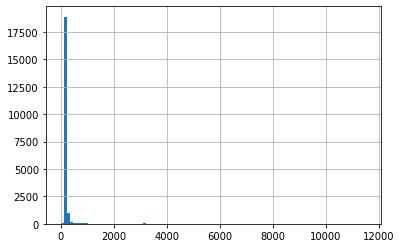

In [10]:
evlog_df.activity_duration_hrs.hist(bins=100)

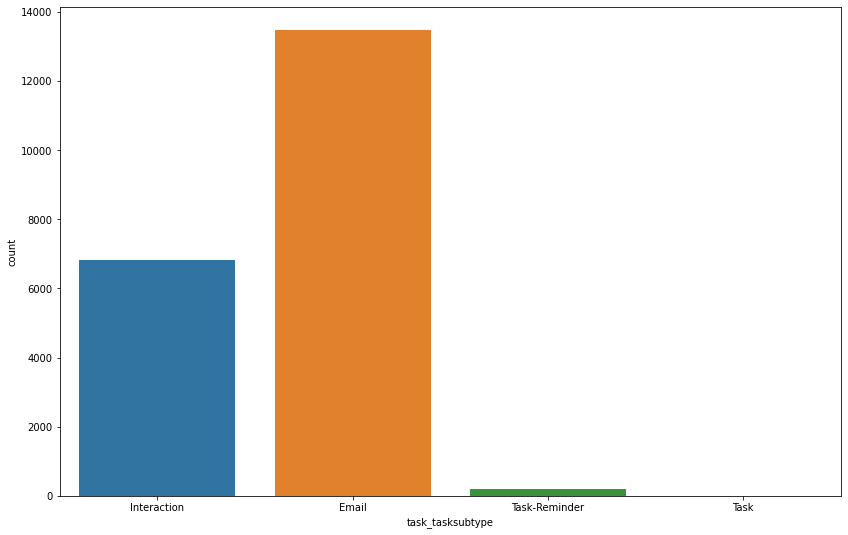

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 9))
ax = sns.countplot(x="task_tasksubtype", data=evlog_df)

<AxesSubplot:>

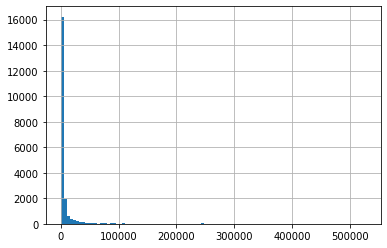

In [12]:
evlog_df.case_resolution_time__c.hist(bins=100)

## Inspection: cases looong activity durations

In [13]:
#day level
#sub = evlog_df.loc[evlog_df.activity_duration > 200]
#sub.head(20)

#from seconds to days
evlog_df["activity_duration_days"] = evlog_df.activity_duration_hrs/24

<ipython-input-13-d33b0ea724af>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evlog_df["activity_duration_days"] = evlog_df.activity_duration_hrs/24


<AxesSubplot:>

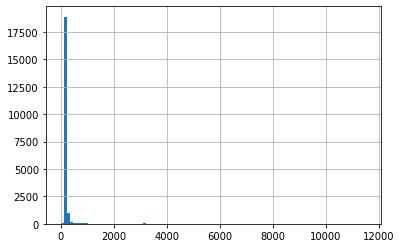

In [14]:
evlog_df.activity_duration_hrs.hist(bins=100)

<AxesSubplot:>

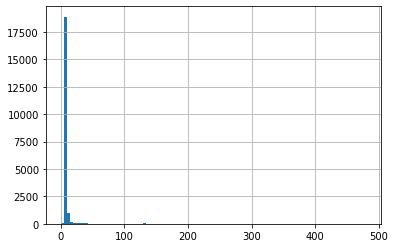

In [15]:
evlog_df.activity_duration_days.hist(bins=100)

## Filter out cases with long durations

In [16]:
threshold = 30
cases = []

for case in list(set(evlog_df.case_id)):
    sub = evlog_df.loc[evlog_df.case_id == case]
    if np.max(sub.activity_duration_days) <= threshold:
        cases.append(sub)

subset = pd.concat(cases,ignore_index=True)
subset = subset.drop_duplicates(subset=["case_id","task_id"])
print(len(df))
print(len(subset))

20484
20221


<AxesSubplot:>

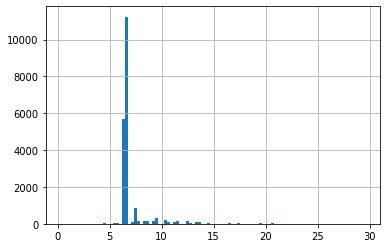

In [17]:
subset.activity_duration_days.hist(bins=100)

# Save filtered table for further analysis and modeling

In [18]:
subset.to_csv("train_evlog_activity_duration_filtered_sub30.csv",index=False)

# Save unfiltered table for further analysis and modeling

In [19]:
evlog_df.to_csv("train_evlog_activity_duration.csv",index=False)